<h2> No retention correction, simply grouped at bw=2 after centWave peak-picking </h2>


In [1]:
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score
#from sklearn.model_selection import StratifiedShuffleSplit
#from sklearn.model_selection import cross_val_score

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle

from scipy import interp
import scipy.stats as stats

%matplotlib inline

/home/irockafe/miniconda2/envs/isaac_revo_healthcare/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def remove_zero_columns(X, threshold=1e-20):
    # convert zeros to nan, drop all nan columns, the replace leftover nan with zeros
    X_non_zero_colum = X.replace(0, np.nan).dropna(how='all', axis=1).replace(np.nan, 0)
    #.dropna(how='all', axis=0).replace(np.nan,0)
    return X_non_zero_colum

def zero_fill_half_min(X, threshold=1e-20):
    # Fill zeros with 1/2 the minimum value of that column
    # input dataframe. Add only to zero values
    
    # Get a vector of 1/2 minimum values
    half_min = X[X > threshold].min(axis=0)*0.5
    
    # Add the half_min values to a dataframe where everything that isn't zero is NaN.
    # then convert NaN's to 0
    fill_vals = (X[X < threshold] + half_min).fillna(value=0)
    
    # Add the original dataframe to the dataframe of zeros and fill-values
    X_zeros_filled = X + fill_vals
    return X_zeros_filled

def prevalence_threshold(df, threshold=0.5):
    '''
    features x samples df
    '''
    print "Requiring sample to be present in %s percent of samples" % threshold
    output = df[((df > 1e-20).sum(axis=1) / df.shape[1]) > threshold]
    return output


toy = pd.DataFrame([[1,2,3,0],
               [0,0,0,0],
               [0.5,1,0,0]], dtype=float)

toy_no_zeros = remove_zero_columns(toy)
toy_filled_zeros = zero_fill_half_min(toy_no_zeros)
print toy
print toy_no_zeros
print toy_filled_zeros

     0    1    2    3
0  1.0  2.0  3.0  0.0
1  0.0  0.0  0.0  0.0
2  0.5  1.0  0.0  0.0
     0    1    2
0  1.0  2.0  3.0
1  0.0  0.0  0.0
2  0.5  1.0  0.0
      0    1    2
0  1.00  2.0  3.0
1  0.25  0.5  1.5
2  0.50  1.0  1.5


<h2> Import the dataframe and remove any features that are all zero </h2>

In [3]:
### Subdivide the data into a feature table
local_path = '/home/irockafe/Dropbox (MIT)/Alm_Lab/'\
'projects'
data_path = local_path + '/revo_healthcare/data/processed/MTBLS72/positive_mode/'\
'mtbls_no_retcor_bw2.csv'

## Import the data and remove extraneous columns
df = pd.read_csv(data_path, index_col=0)
print df.columns
new_idx = [i.replace('X', '') for i in df.columns]
df.columns = new_idx

df.shape
df.head()
# Make a new index of mz:rt
mz = df.loc[:,"mz"].astype('str')
rt = df.loc[:,"rt"].astype('str')
idx = mz+':'+rt
df.index = idx

# separate samples from xcms/camera things to make feature table
not_samples = ['mz', 'mzmin', 'mzmax', 'rt', 'rtmin', 'rtmax', 
               'npeaks', 'positive_mode', 
               ]
samples_list = df.columns.difference(not_samples)
mz_rt_df = df[not_samples]

# convert to samples x features
X_df_raw = df[samples_list].T
# Replace X's at the beginning of columns
new_idx = [i.replace('X', '') for i in X_df_raw.index]
X_df_raw.index = new_idx
# Remove zero-full columns and fill zeroes with 1/2 minimum values
X_df = remove_zero_columns(X_df_raw)
X_df_zero_filled = zero_fill_half_min(X_df)

print "original shape: %s \n# zeros: %f\n" % (X_df_raw.shape, (X_df_raw < 1e-20).sum().sum())
print "zero-columns and NaNs repalced? shape: %s \n# zeros: %f\n" % (X_df.shape, 
                                                         (X_df < 1e-20).sum().sum())
print "zeros filled shape: %s \n#zeros: %f\n" % (X_df_zero_filled.shape, 
                                              (X_df_zero_filled < 1e-20).sum().sum())


# Convert to numpy matrix to play nicely with sklearn
#X = X_df.as_matrix()
#print X.shape
#print X_df.head()

Index([u'mz', u'mzmin', u'mzmax', u'rt', u'rtmin', u'rtmax', u'npeaks',
       u'positive_mode', u'X20120829_Howard_POS_07',
       u'X20120829_Howard_POS_08',
       ...
       u'X20120829_Howard_POS_89', u'X20120829_Howard_POS_90',
       u'X20120829_Howard_POS_91', u'X20120829_Howard_POS_92',
       u'X20120829_Howard_POS_93', u'X20120829_Howard_POS_94',
       u'X20120829_Howard_POS_95', u'X20120829_Howard_POS_96',
       u'X20120829_Howard_POS_98', u'X20120829_Howard_POS_99'],
      dtype='object', length=262)
original shape: (254, 1417) 
# zeros: 0.000000

zero-columns and NaNs repalced? shape: (254, 1417) 
# zeros: 83441.000000

zeros filled shape: (254, 1417) 
#zeros: 0.000000



<h2> Get mappings between sample names, file names, and sample classes </h2>

In [4]:
# get mapping between sample name and sample class
path_sample_class_map = local_path + '/revo_healthcare/data/raw/MTBLS72/s_Plasma_AD_Lipidomics.txt'
class_column = 'Factor Value[Cognitive Status]'

class_df = pd.read_csv(path_sample_class_map,
                      sep='\t')
# Set index as sample name
class_df.set_index('Sample Name', inplace=True)
class_df = class_df[class_column]
# select only positive values
class_df = class_df[class_df.index.str.contains('POS')]
print class_df.head(10)
print "Class label shape: ", class_df.shape
print "feature table shape: ", X_df.shape

#class_df.rename('class', inplace=True)
print class_df.head()
pd.unique(class_df.values)


Sample Name
20120829_Howard_POS_129    aMCI/AD
20120829_Howard_POS_130    aMCI/AD
20120829_Howard_POS_131    aMCI/AD
20120829_Howard_POS_132    aMCI/AD
20120829_Howard_POS_134    aMCI/AD
20120829_Howard_POS_135    aMCI/AD
20120829_Howard_POS_137    aMCI/AD
20120829_Howard_POS_142    aMCI/AD
20120829_Howard_POS_158    aMCI/AD
20120829_Howard_POS_160    aMCI/AD
Name: Factor Value[Cognitive Status], dtype: object
Class label shape:  (323,)
feature table shape:  (254, 1417)
Sample Name
20120829_Howard_POS_129    aMCI/AD
20120829_Howard_POS_130    aMCI/AD
20120829_Howard_POS_131    aMCI/AD
20120829_Howard_POS_132    aMCI/AD
20120829_Howard_POS_134    aMCI/AD
Name: Factor Value[Cognitive Status], dtype: object


array(['aMCI/AD', 'Normal Control', 'Not Applicable'], dtype=object)

<h4>Control is 0, alzheimers is 1 </h4>
Not that the 'Not Applicable' class is not part of my dataframe, X, so when we make sure that X and y refer to the same samples, all the 'Not Applicable' samples are dropped

In [5]:
# Match between feature table and metadata and assert that they're in the same order.
# then define the numpy-arrays for X and y
class_df = class_df[X_df.index].sort_index()
X_df = X_df.sort_index()

assert (class_df.index == X_df.index).all()

X = X_df.as_matrix()

# convert classes to numbers
le = preprocessing.LabelEncoder()
le.fit(class_df)
y = le.transform(class_df)
print y

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 1 1
 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 0 1 0 1
 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0
 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1
 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


[[  1.   1.   1.]
 [  2.   2.   2.]
 [  3.   6.   9.]
 [  6.  12.  18.]]
[[  1.   1.   1.   2.   2.   2.   3.   6.   9.   6.  12.  18.]]
allquotients reshaped!

(3,)


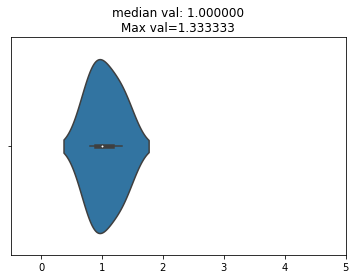

allquotients reshaped!

(3,)


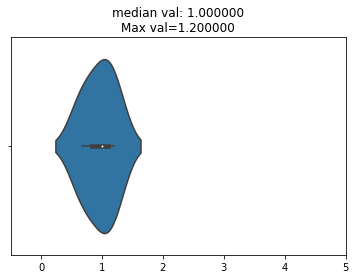

allquotients reshaped!

(3,)


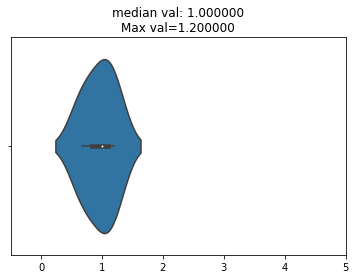

[[ 0.33333333  0.33333333  0.33333333]
 [ 0.33333333  0.33333333  0.33333333]
 [ 0.16666667  0.33333333  0.5       ]
 [ 0.16666667  0.33333333  0.5       ]]




[[ 4.  4.  4.]
 [ 4.  4.  4.]
 [ 2.  4.  6.]
 [ 2.  4.  6.]]


In [6]:
# TODO PQN normalization, and log-transformation, 
# and some feature selection (above certain threshold of intensity, use principal components), et

def pqn_normalize(X, integral_first=False, plot=False):
    '''
    Take a feature table and run PQN normalization on it
    samples x features table
    '''
    # normalize by sum of intensities in each sample first. Not necessary
    if integral_first: 
        sample_sums = np.sum(X, axis=1)
        X = (X / sample_sums[:,np.newaxis])
    
    # Get the median value of each feature across all samples
    mean_intensities = np.median(X, axis=0)
    
    # Divde each feature by the median value of each feature - 
    # these are the quotients for each feature
    X_quotients = (X / mean_intensities[np.newaxis,:])
    
    if plot: # plot the distribution of quotients from one sample
        for i in range(1,len(X_quotients[:,1])):
            print 'allquotients reshaped!\n\n', 
            #all_quotients = X_quotients.reshape(np.prod(X_quotients.shape))
            all_quotients = X_quotients[i,:]
            print all_quotients.shape
            x = np.random.normal(loc=0, scale=1, size=len(all_quotients))
            sns.violinplot(all_quotients)
            plt.title("median val: %f\nMax val=%f" % (np.median(all_quotients), np.max(all_quotients)))
            plt.plot( title="median val: ")#%f" % np.median(all_quotients))
            plt.xlim([-0.5, 5])
            plt.show()

    # Define a quotient for each sample as the median of the feature-specific quotients
    # in that sample
    sample_quotients = np.median(X_quotients, axis=1)
    
    # Quotient normalize each samples
    X_pqn = X / sample_quotients[:,np.newaxis]
    return X_pqn

# Make a fake sample, with 2 samples at 1x and 2x dilutions
X_toy = np.array([[1,1,1,],
                  [2,2,2],
                  [3,6,9],
                  [6,12,18]], dtype=float)
print X_toy
print X_toy.reshape(1, np.prod(X_toy.shape))
X_toy_pqn_int = pqn_normalize(X_toy, integral_first=True, plot=True)
print X_toy_pqn_int

print '\n\n\n'
X_toy_pqn = pqn_normalize(X_toy)
print X_toy_pqn

<h2> pqn normalize your features </h2>

In [10]:
X_pqn = pqn_normalize(X)
print X_pqn

[[  2376.68354621   2632.79600443  13599.57019084 ...,   2316.63382316
    2019.66847599    446.83641138]
 [  2895.79115719   2982.04128079  15946.90497631 ...,   2190.68836264
    2925.0567903     645.62885272]
 [     0.           3992.6417963   16528.77236548 ...,   2220.2094898
    1848.15195494    623.7804676 ]
 ..., 
 [     0.              0.              0.         ...,      0.              0.
       0.        ]
 [  2337.76090654      0.          37674.85217975 ...,      0.
    2609.61532135    654.76842215]
 [     0.              0.          36787.00296048 ...,      0.              0.
       0.        ]]


/home/irockafe/miniconda2/envs/isaac_revo_healthcare/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in divide
/home/irockafe/miniconda2/envs/isaac_revo_healthcare/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in divide


<h2>Random Forest & adaBoost with PQN-normalized data</h2>

In [8]:
def roc_curve_cv(X, y, clf, cross_val,
                path='/home/irockafe/Desktop/roc.pdf',
                save=False, plot=True):  
    '''
    PURPOSE:
        Creates an ROC curve
    INPUT:    
        X - (samples x features) numpy array
        y - (samles,) numpy array
        clf - classifier to use
        cross_val - cross-validation strategy to use
        path- where to dump a pdf of the cross-validated ROC curve
    '''
    t1 = time.time()
    # collect vals for the ROC curves
    tpr_list = []
    mean_fpr = np.linspace(0,1,100)
    auc_list = []
    
    # Get the false-positive and true-positive rate
    for i, (train, test) in enumerate(cross_val):
        clf.fit(X[train], y[train])
        y_pred = clf.predict_proba(X[test])[:,1]
        
        # get fpr, tpr
        fpr, tpr, thresholds = roc_curve(y[test], y_pred)
        roc_auc = auc(fpr, tpr)
        #print 'AUC', roc_auc
        #sns.plt.plot(fpr, tpr, lw=10, alpha=0.6, label='ROC - AUC = %0.2f' % roc_auc,)
        #sns.plt.show()
        tpr_list.append(interp(mean_fpr, fpr, tpr))
        tpr_list[-1][0] = 0.0
        auc_list.append(roc_auc)
        
        if (i % 10 == 0):
            print '{perc}% done! {time}s elapsed'.format(perc=100*float(i)/cross_val.n_iter, time=(time.time() - t1))          
               
    # get mean tpr and fpr
    mean_tpr = np.mean(tpr_list, axis=0)
    # make sure it ends up at 1.0
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(auc_list)
    
    if plot:
        # plot mean auc
        plt.plot(mean_fpr, mean_tpr, label='Mean ROC - AUC = %0.2f $\pm$ %0.2f' % (mean_auc, 
                                                                                       std_auc),
                    lw=5, color='b')

        # plot luck-line
        plt.plot([0,1], [0,1], linestyle = '--', lw=2, color='r',
                    label='Luck', alpha=0.5) 

        # plot 1-std
        std_tpr = np.std(tpr_list, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                            label=r'$\pm$ 1 stdev')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve, {iters} iterations of {cv} cross validation'.format(
            iters=cross_val.n_iter, cv='{train}:{test}'.format(test=cross_val.test_size, train=(1-cross_val.test_size)))
                 )
        plt.legend(loc="lower right")

        if save:
            plt.savefig(path,  format='pdf')


        plt.show()
    return tpr_list, auc_list, mean_fpr

3
0.3
0.0% done! 3.9932820797s elapsed


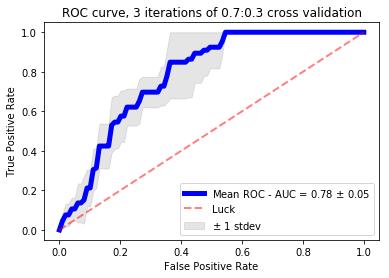

In [9]:


rf_estimators = 1000
n_iter = 3
test_size = 0.3
random_state = 1
cross_val_rf = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size, random_state=random_state)
clf_rf = RandomForestClassifier(n_estimators=rf_estimators, random_state=random_state)

print cross_val_rf.n_iter
print cross_val_rf.test_size

tpr_vals, auc_vals, mean_fpr = roc_curve_cv(X, y, clf_rf, cross_val_rf,
                                           save=False)

0.0% done! 4.0625231266s elapsed


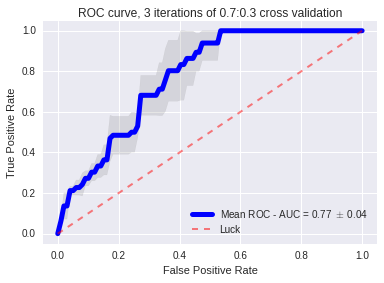

In [23]:
# For adaboosted
n_iter = 3
test_size = 0.3
random_state = 1
adaboost_estimators = 200



cross_val_adaboost = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size, random_state=random_state)
clf = AdaBoostClassifier(n_estimators=adaboost_estimators, random_state=random_state)
adaboost_tpr, adaboost_auc, adaboost_fpr = roc_curve_cv(X, y, clf, cross_val_adaboost,
                                                       )

<h2> Great, you can classify things. But make null models and do a sanity check to make 
sure you arent just classifying garbage </h2>

In [10]:
# Make a null model AUC curve

def make_null_model(X, y, clf, cross_val, random_state=1, num_shuffles=5, plot=True):
    '''
    Runs the true model, then sanity-checks by:
    
    Shuffles class labels and then builds cross-validated ROC curves from them.
    TODO: Compare true AUC vs. shuffled auc by t-test (assumes normality of AUC curve)
    '''
    null_aucs = []
    print y.shape
    print X.shape
    tpr_true, auc_true, fpr_true = roc_curve_cv(X, y, clf, cross_val, save=True)
    # shuffle y lots of times
    for i in range(0, num_shuffles):
        #Iterate through the shuffled y vals and repeat with appropriate params
        # Retain the auc vals for final plotting of distribution
        y_shuffle = shuffle(y)
        cross_val.y = y_shuffle
        cross_val.y_indices = y_shuffle
        print 'Number of differences b/t original and shuffle: %s' % (y == cross_val.y).sum()
        # Get auc values for number of iterations
        tpr, auc, fpr = roc_curve_cv(X, y_shuffle, clf, cross_val, plot=True)
        
        null_aucs.append(auc)
    
    
    #plot the outcome as violinplots of auc curves
    if plot:
        flattened_aucs = [j for i in null_aucs for j in i]
        my_dict = {'true_auc': auc_true, 'null_auc': flattened_aucs}
        df_poop =  pd.DataFrame.from_dict(my_dict, orient='index').T
        df_tidy = pd.melt(df_poop, value_vars=['true_auc', 'null_auc'],
                         value_name='auc', var_name='AUC_type')
        #print flattened_aucs
        sns.violinplot(x='AUC_type', y='auc',
            inner='points', data=df_tidy)
        # Plot distribution of AUC vals   
        plt.title("Distribution of aucs")
        #sns.plt.ylabel('count')
        plt.xlabel('AUC')
        #sns.plt.plot(auc_true, 0, color='red', markersize=10)
        plt.show()
    # Do a quick t-test to see if odds of randomly getting an AUC that good
    return auc_true, null_aucs


(254,)
(254, 1417)
0.0% done! 4.45924210548s elapsed
20.0% done! 78.9431581497s elapsed
40.0% done! 143.782060146s elapsed
60.0% done! 188.889692068s elapsed
80.0% done! 230.896824121s elapsed


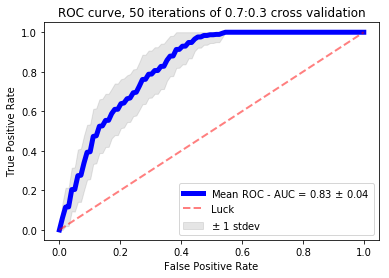

Number of differences b/t original and shuffle: 146
0.0% done! 4.78017687798s elapsed
20.0% done! 56.8655638695s elapsed
40.0% done! 105.429105043s elapsed
60.0% done! 150.889708042s elapsed
80.0% done! 197.193608046s elapsed


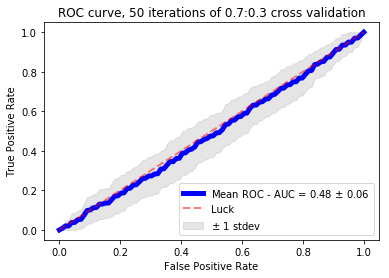

Number of differences b/t original and shuffle: 150
0.0% done! 4.63375210762s elapsed
20.0% done! 52.5110690594s elapsed
40.0% done! 102.090430021s elapsed
60.0% done! 151.704711914s elapsed
80.0% done! 202.616847992s elapsed


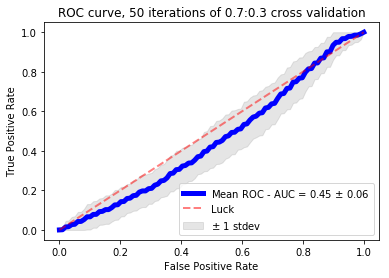

Number of differences b/t original and shuffle: 140
0.0% done! 4.52952599525s elapsed
20.0% done! 50.0040450096s elapsed
40.0% done! 93.9484059811s elapsed
60.0% done! 140.00563693s elapsed
80.0% done! 188.164286137s elapsed


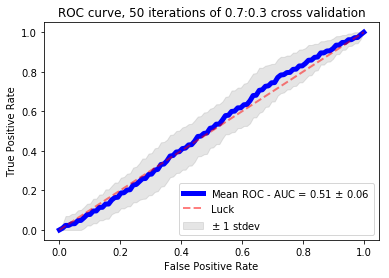

Number of differences b/t original and shuffle: 142
0.0% done! 4.62021303177s elapsed
20.0% done! 55.9427940845s elapsed
40.0% done! 109.53305006s elapsed
60.0% done! 158.867068052s elapsed
80.0% done! 204.473369122s elapsed


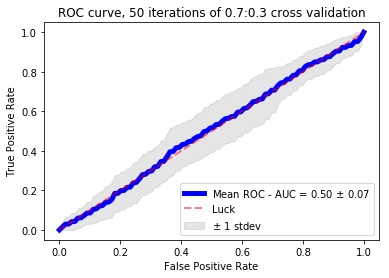

Number of differences b/t original and shuffle: 154
0.0% done! 4.78358602524s elapsed
20.0% done! 52.0092451572s elapsed
40.0% done! 96.5998790264s elapsed
60.0% done! 141.035567045s elapsed
80.0% done! 189.470935106s elapsed


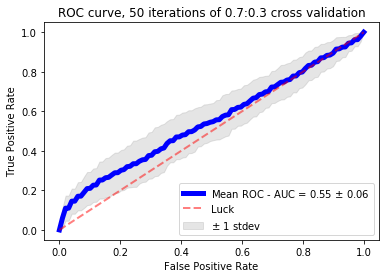

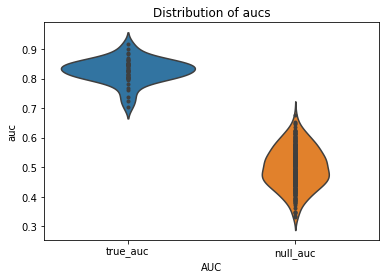

In [11]:
# Make a null model AUC curve & compare it to null-model

# Random forest magic!
rf_estimators = 1000
n_iter = 50
test_size = 0.3
random_state = 1
cross_val_rf = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size, random_state=random_state)
clf_rf = RandomForestClassifier(n_estimators=rf_estimators, random_state=random_state)

true_auc, all_aucs = make_null_model(X, y, clf_rf, cross_val_rf, num_shuffles=5)

   AUC_type       auc
0  true_auc  0.816116
1  true_auc  0.822727
2  true_auc  0.703306
3  true_auc  0.847107
4  true_auc  0.901653


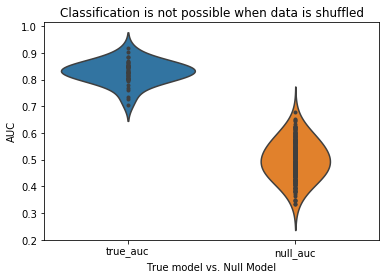

In [12]:
# make dataframe from true and false aucs
flattened_aucs = [j for i in all_aucs for j in i]
my_dict = {'true_auc': true_auc, 'null_auc': flattened_aucs}
df_poop =  pd.DataFrame.from_dict(my_dict, orient='index').T
df_tidy = pd.melt(df_poop, value_vars=['true_auc', 'null_auc'],
                 value_name='auc', var_name='AUC_type')
print df_tidy.head()
#print flattened_aucs
sns.violinplot(x='AUC_type', y='auc',
    inner='points', data=df_tidy, bw=0.7)
plt.title("Classification is not possible when data is shuffled")
#sns.plt.ylabel('count')
plt.xlabel('True model vs. Null Model')
plt.ylabel('AUC')
#sns.plt.plot(auc_true, 0, color='red', markersize=10)
plt.savefig('/home/irockafe/Desktop/auc distribution', format='pdf')
plt.show()



<h2> Let's look at a slice of retention time </h2>

In [ ]:
# def get_rt_slice(df, rt_bounds):
    '''
    PURPOSE: 
        Given a tidy feature table with 'mz' and 'rt' column headers, 
        retain only the features whose rt is between rt_left 
        and rt_right
    INPUT: 
        df - a tidy pandas dataframe with 'mz' and 'rt' column 
            headers (i.e. from xcms)
        rt_left, rt_right: the boundaries of your rt_slice, in seconds
    '''
    out_df = df.loc[ (df['rt'] > rt_bounds[0]) & 
                    (df['rt'] < rt_bounds[1])]
    return out_df

def process_xcms_input(df, threshold=0.5):
    '''
    INPUT - pandas dataframe and threshold for sample prevalence
    Remove extranneous columns, and any features that have zeros across hte board
    '''
    # separate samples from xcms/camera things to make feature table
    not_samples = ['mz', 'mzmin', 'mzmax', 'rt', 'rtmin', 'rtmax', 
                   'npeaks', 'positive_mode', 
                   ]
    samples_list = df.columns.difference(not_samples)
    mz_rt_df = df[not_samples]

    # convert to samples x features
    X_df_raw = df[samples_list].T
    # Replace X's at the beginning of columns
    new_idx = [i.replace('X', '') for i in X_df_raw.index]
    X_df_raw.index = new_idx
    # Remove columns present in less than threshold% of samples
    # remember columns are features
    X_df = prevalence_threshold(X_df_raw, threshold=threshold)
    #X_df = remove_zero_columns(X_df_raw)
    #X_df_zero_filled = zero_fill_half_min(X_df)
    return X_df

#df.head()
my_slice = (550,670)
df_slice = get_rt_slice(df, my_slice)
print df_slice.shape

X_df = process_xcms_input(df_slice)

X_slice = X_df.as_matrix()
# pqn-normalize
X_slice_pqn = pqn_normalize(X)
print 'Shape of dataframe:', X_df.shape
print X_df.head()

In [12]:
# Match between feature table and metadata and assert that they're in the same order.
# then define the numpy-arrays for X and y
class_df = class_df[X_df.index].sort_index()
X_df = X_df.sort_index()

assert (class_df.index == X_df.index).all()

X = X_df.as_matrix()

# convert classes to numbers
le = preprocessing.LabelEncoder()
le.fit(class_df)
y = le.transform(class_df)
print y

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 1 1
 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 0 1 0 1
 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0
 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1
 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


(254,)
(254, 446)
0.0% done! 3.603992939s elapsed


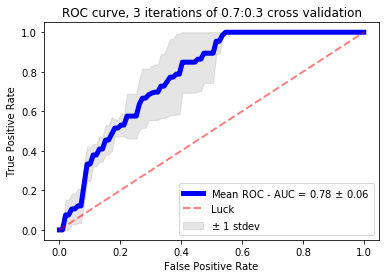

Number of differences b/t original and shuffle: 160
0.0% done! 4.3977458477s elapsed


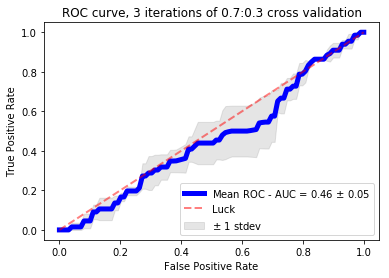

Number of differences b/t original and shuffle: 152
0.0% done! 4.60083317757s elapsed


KeyboardInterrupt: 

In [23]:
# Make a null model AUC curve & compare it to null-model
# For the slice of retention time

# Random forest magic!
rf_estimators = 1000
n_iter = 50
test_size = 0.3
random_state = 1
cross_val_rf = StratifiedShuffleSplit(y, n_iter=n_iter, 
                    test_size=test_size, random_state=random_state)
clf_rf = RandomForestClassifier(n_estimators=rf_estimators, 
                    random_state=random_state)

true_auc, all_aucs = make_null_model(X, y, clf_rf, cross_val_rf, num_shuffles=5)

   AUC_type       auc
0  true_auc  0.811983
1  true_auc  0.819421
2  true_auc  0.695041
3  true_auc  0.870248
4  true_auc  0.893802


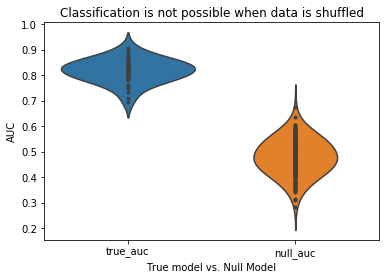

In [31]:
# make dataframe from true and false aucs
flattened_aucs = [j for i in all_aucs for j in i]
my_dict = {'true_auc': true_auc, 'null_auc': flattened_aucs}
df_poop =  pd.DataFrame.from_dict(my_dict, orient='index').T
df_tidy = pd.melt(df_poop, value_vars=['true_auc', 'null_auc'],
                 value_name='auc', var_name='AUC_type')
print df_tidy.head()
#print flattened_aucs
sns.violinplot(x='AUC_type', y='auc',
    inner='points', data=df_tidy, bw=0.7)
plt.title("Classification is not possible when data is shuffled")
#sns.plt.ylabel('count')
plt.xlabel('True model vs. Null Model')
plt.ylabel('AUC')
#sns.plt.plot(auc_true, 0, color='red', markersize=10)
plt.savefig('/home/irockafe/Desktop/auc_distribution', format='pdf')
plt.show()



<h2> Run sliding window across retention times and see how classification changes
</h2>

661.766511
998.775098907
ymin:  34.9598918644


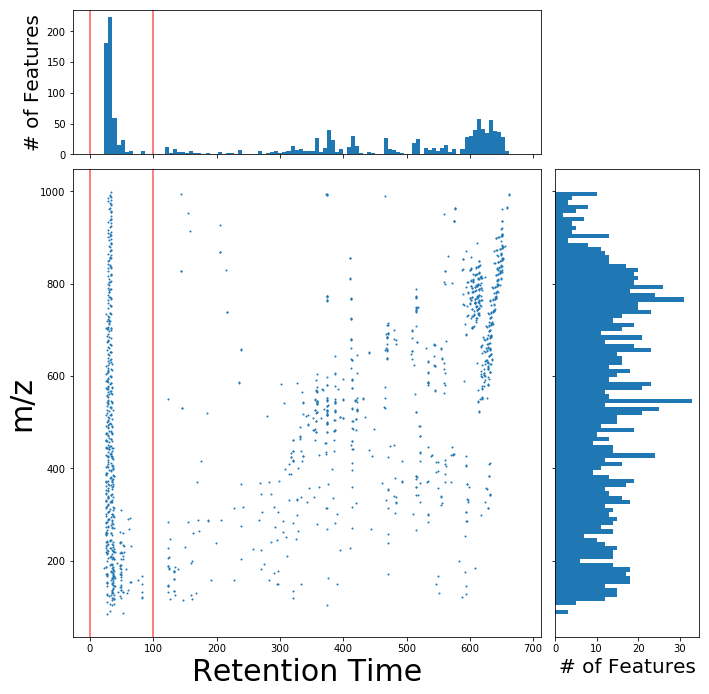

Requiring sample to be present in 0.5 percent of samples
slice shape (248, 517)
y shape (253,)


IndexError: index 251 is out of bounds for axis 0 with size 248

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter


def plot_mz_rt(df, rt_bounds, path='/home/irockafe/Desktop/poop.pdf'):
    '''
    PURPOSE: Plot the mz/rt space of your dataset, 
        along with histograms of the rt and mz presence
    INPUT: 
        df - a pandas dataframe feature table, 
            containing columns labeled 'rt' and 'mz', along with
            the sample columns
        rt_bounds - iterable containing retention time bounds
            for a particular slice: (left bound, right bound)
        path - where to save the figure to.
    OUTPUT:
        a pdf file showing mz/rt points and the rt-bound
        
    '''
    
    # the random data
    x = df['rt']
    y = df['mz']
    print np.max(x)
    print np.max(y)
    nullfmt = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # start with a rectangular Figure
    #fig = plt.figure(1, figsize=(8, 8))
    fig = plt.figure(1, figsize=(10,10))
    
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)

    # the scatter plot:
    axScatter.scatter(x, y, s=1)

    # now determine nice limits by hand:
    binwidth = 0.25

    #xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])

    #lim = (int(xymax/binwidth) + 1) * binwidth

    x_min = np.min(x)-50
    x_max = np.max(x)+50
    axScatter.set_xlim(x_min, x_max )
    y_min = np.min(y)-50
    y_max = np.max(y)+50
    axScatter.set_ylim(y_min, y_max)

    # Add vertical red line between 750-1050 retention time
    '''
    plt.plot([0,1], [0,1], linestyle = '--', lw=2, color='r',
                        label='Luck', alpha=0.5)
    '''
    print 'ymin: ', y_min
    # Add vertical/horizontal lines to scatter and histograms
    axScatter.axvline(x=rt_bounds[0], lw=2, color='r', alpha=0.5)
    axScatter.axvline(x=rt_bounds[1], lw=2, color='r', alpha=0.5)

    axHistx.axvline(x=rt_bounds[0], lw=2, color='r', alpha=0.5)
    axHistx.axvline(x=rt_bounds[1], lw=2, color='r', alpha=0.5)

    #bins = np.arange(-lim, lim + binwidth, binwidth)
    bins = 100
    axHistx.hist(x, bins=bins)
    axHisty.hist(y, bins=bins, orientation='horizontal')

    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())

    axScatter.set_ylabel('m/z', fontsize=30)
    axScatter.set_xlabel('Retention Time', fontsize=30)

    axHistx.set_ylabel('# of Features', fontsize=20)
    axHisty.set_xlabel('# of Features', fontsize=20)
        
    plt.savefig(path, 
                format='pdf')
    plt.show()

def slice_and_predict(df, y, rt_slice, threshold=0.5,
                     rf_estimators=1000, 
                     n_iter=10, test_size=0.3, random_state=1,
                     mzrt_path='/home/irockafe/Desktop/poop.pdf',
                     ):
    '''
    df - pandas dataframe, from xcms, that includes columns with 'mz'
       and 'rt'
    y - class-labels encoded by scikit LabelEncoder. Make sure their order matches
        the dataframe's
        
    Note that in the process_xcms_input() function needs to be modifier
       for each dataset, if there are column names that change between 
       datasets. So, you'll have to modify it.
    '''
    
    # plot selection 
    plot_mz_rt(df, rt_slice, path=mzrt_path)    
    # Get slice and convert to feature table
    df_slice = get_rt_slice(df, rt_slice)
    # remove columns with adduct info, extranneous stuff,
    # mz, rt, etc
    df_slice_processed = process_xcms_input(df_slice, threshold)
    X_slice = df_slice_processed.as_matrix()
    print "slice shape", X_slice.shape
    print 'y shape', y.shape

    # Run RF
    rf_estimators = rf_estimators
    n_iter = n_iter
    test_size = test_size
    random_state = random_state
    cross_val_rf = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size, random_state=random_state)
    clf_rf = RandomForestClassifier(n_estimators=rf_estimators, random_state=random_state)
    tpr_vals, auc_vals, mean_fpr = roc_curve_cv(X_slice, y, clf_rf, cross_val_rf,
                                               save=False)
    


rt_slice = (0,100)
slice_and_predict(df, y, rt_slice, n_iter=3, rf_estimators=100)

In [15]:
# Run through rt window
def make_sliding_window(min_val, max_val, width, step):
    '''
    PURPOSE: Create a sliding window given min, max, window width
        and step-size
    INPUT: 
        min_val: Minimum value
        max_val: Maximum value
        width: Window width
        step: stepsize for each window
    OUTPUT:
        list of tuples [(left,right),(left2, right2),...]
        that give the bounds of a sliding window
    '''
    if step > width:
        raise ValueError, ("Your step should be less than"+
                           "or equal to the width of the window")
    left_bound = np.arange(min_val, max_val, step)
    right_bound = left_bound + width
    rt_bounds = zip(left_bound, right_bound)
    # remove any bounds that go past the maximum value
    for idx, i in enumerate(rt_bounds):
        if i[1] > max_val:
            rt_bounds.pop(idx)
    return rt_bounds

make_sliding_window(0, 100, 10, 5)

[(0, 10),
 (5, 15),
 (10, 20),
 (15, 25),
 (20, 30),
 (25, 35),
 (30, 40),
 (35, 45),
 (40, 50),
 (45, 55),
 (50, 60),
 (55, 65),
 (60, 70),
 (65, 75),
 (70, 80),
 (75, 85),
 (80, 90),
 (85, 95),
 (90, 100)]

min: 0, max: 661.766511, width: 132.3533022, step: 66.1766511
[(0.0, 132.3533022), (66.176651100000001, 198.52995329999999), (132.3533022, 264.7066044), (198.52995329999999, 330.88325550000002), (264.7066044, 397.05990659999998), (330.88325550000002, 463.23655770000005), (397.05990659999998, 529.41320880000001), (463.23655769999999, 595.58985989999996), (529.41320880000001, 661.76651100000004)]
RT plot (0.0, 132.3533022)
661.766511
998.775098907
ymin:  34.9598918644


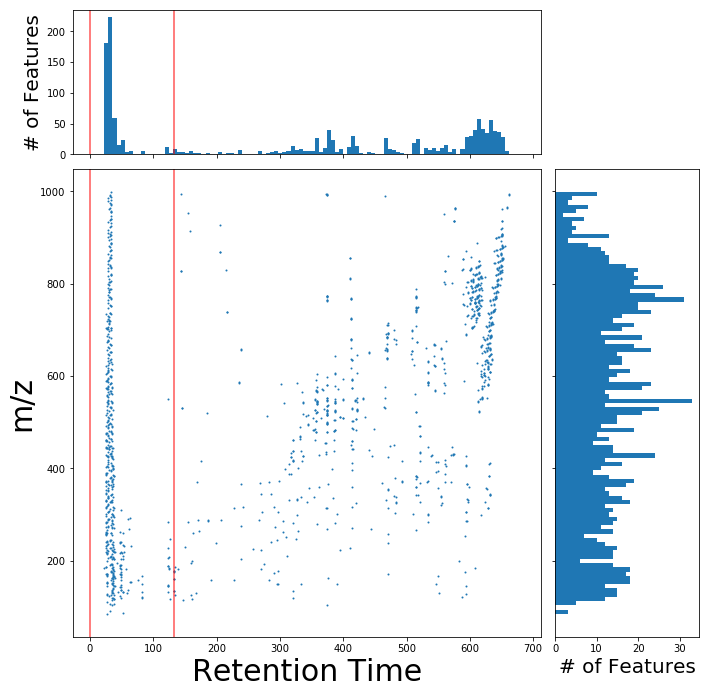

Requiring sample to be present in 0.5 percent of samples
slice shape (249, 533)
y shape (253,)


IndexError: index 251 is out of bounds for axis 0 with size 249

In [16]:
# Make sliding window
min_val = 0
max_val = df['rt'].max()
width = max_val / 5.0
step = width / 2
print "min: {mini}, max: {maxi}, width: {width}, step: {step}".format(
        mini=min_val, maxi=max_val, width=width, step=step)
sliding_window = make_sliding_window(min_val, max_val, width, step)
print sliding_window

# plot and run classifier on sliding window
for rt_slice in sliding_window:
    print 'RT plot', rt_slice
    slice_and_predict(df, y, rt_slice,
                      rf_estimators=1000, 
                     n_iter=25, test_size=0.3, random_state=1)
    print '\n\n\n'+'-'*50+'NEXT ROUND'+'-'*50+'\n\n\n'

<h2> This feels like bullshit. Try to PQN-normalize to see if there's a concentration-factor difference accounting for this stuff </h2>
They randomized the sample injection order, so that's not the issue.

Check to see if their are the right number of people

maybe pick random feature within

class_labels shape:  (254,)
Dataframe shape (1417, 262)
['Normal Control' 'aMCI/AD']
case shape:  (72, 1417)
control shape (182, 1417)


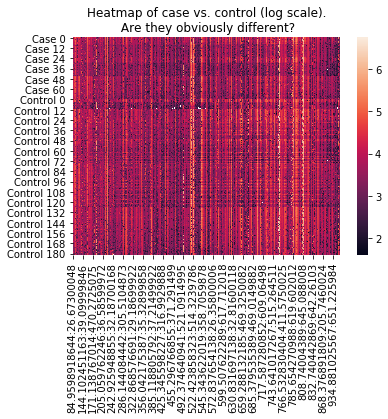

In [8]:
# plot intensity distributions for each group
print 'class_labels shape: ', class_df.shape
print 'Dataframe shape', df.shape
print class_df.unique()
# separate samples from xcms/camera things to make feature table
not_samples = ['mz', 'mzmin', 'mzmax', 'rt', 'rtmin', 'rtmax', 
               'npeaks', 'positive_mode', 
               ]
samples_list = df.columns.difference(not_samples)
mz_rt_df = df[not_samples]

# convert to samples x features
X_df_raw = df[samples_list].T
# Replace X's at the beginning of columns
new_idx = [i.replace('X', '') for i in X_df_raw.index]
X_df_raw.index = new_idx

case_labels = class_df[class_df=='aMCI/AD'].index
control_labels = class_df[class_df == 'Normal Control'].index
case = X_df_raw.loc[case_labels]
control = X_df_raw.loc[control_labels]

# plot distributions of intensity
case_idx = {i: 'Case %s' % j for j, i in enumerate(case.index)}
case.index = ['Case %s' % i for i in range(0, len(case.index))]
control.index = ['Control %s' % i for i in range(0, len(control.index))]
print 'case shape: ', case.shape
print 'control shape',  control.shape
sns.heatmap(pd.concat([np.log10(case), np.log10(control)]))
plt.title('Heatmap of case vs. control (log scale).\n Are they obviously different?')
plt.show()


In [106]:
# mannwhitney? 


mann_whitney_vals = pd.DataFrame(np.full([case.shape[1],2], np.nan),
                              index=case.columns, columns= ['u', 'pval'])
for idx, case_vals in case.iteritems():
    control_vals = control[idx]
    u, pval = stats.mannwhitneyu(case_vals, control_vals)
    mann_whitney_vals.loc[idx, 'u'] = u
    mann_whitney_vals.loc[idx, 'pval'] = pval


    
# Try volcano-like plot for retention time vs. p-val

NameError: name 'case' is not defined

(1417, 2)


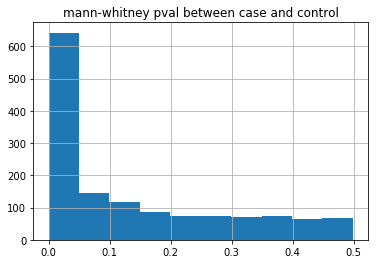

In [197]:
print mann_whitney_vals.shape
mann_whitney_vals.hist('pval')
plt.title('mann-whitney pval between case and control')

<h2> Looks like there are just a TON of differentiating features between these groups. Like ~45% of features are distinct </h2>

Index([u'907.852628702:649.969998', u'730.53917234:595.5139734',
       u'598.504928985:618.663996', u'216.018607322:50.2709985',
       u'170.066796436:26.51700051', u'829.556587848:600.715512',
       u'415.211814255:320.3100012', u'668.375278306:543.4374903',
       u'226.180554864:258.1410024', u'626.53626936:623.06202'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
907.852628702:649.969998


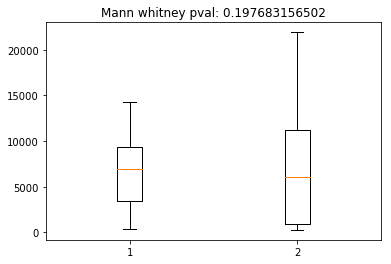

730.53917234:595.5139734


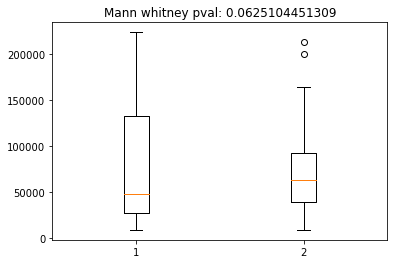

598.504928985:618.663996


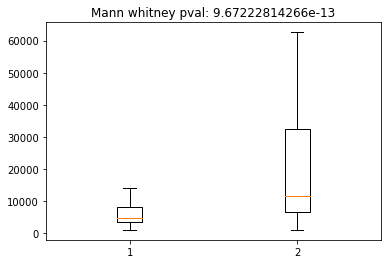

216.018607322:50.2709985


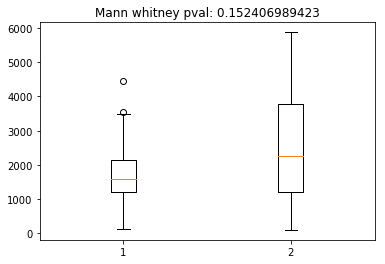

170.066796436:26.51700051


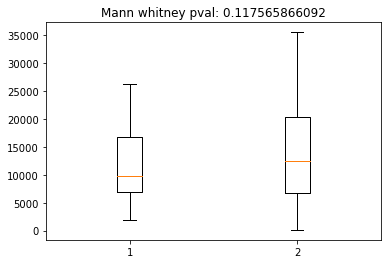

829.556587848:600.715512


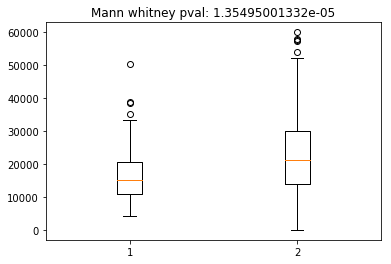

415.211814255:320.3100012


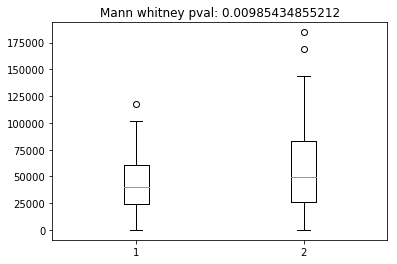

668.375278306:543.4374903


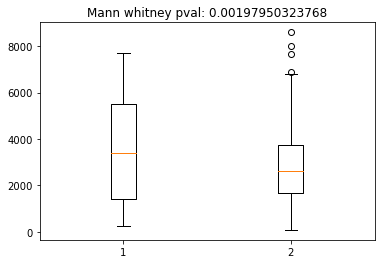

226.180554864:258.1410024


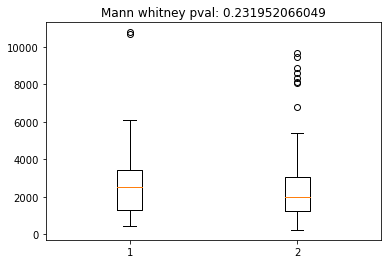

626.53626936:623.06202


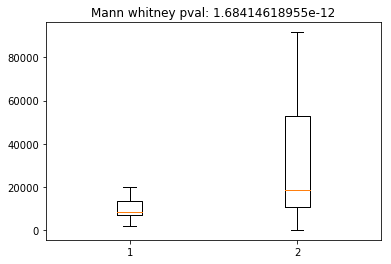

In [208]:
num = np.random.randint(case.shape[1], size = 10)
idx = mann_whitney_vals.index[num]
print idx
print type(case)
for i in idx:
    case_vals = case.loc[:,i]
    control_vals = control.loc[:,i]
    plt.boxplot([case_vals.dropna(), control_vals.dropna()])
    #sns.boxplot( y=case_vals)
    #sns.boxplot(y=control_vals)
    print i
    plt.title('Mann whitney pval: {p}'.format(
        p=mann_whitney_vals.loc[i, 'pval']))
    plt.show()
    

MannwhitneyuResult(statistic=888753.0, pvalue=6.1537580727010658e-08)

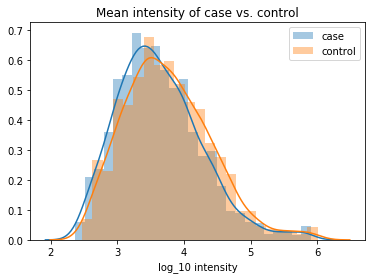

In [236]:
# plot distribution of mean intensities
case_mean = case[case > 10].mean(axis=0)
ctrl_mean = control[control>10].mean(axis=0)
sns.distplot(np.log10(case_mean), label='case')
sns.distplot(np.log10(ctrl_mean), label='control')
plt.xlabel('log_10 intensity')
plt.title('Mean intensity of case vs. control')
plt.legend()

stats.mannwhitneyu(case_mean, ctrl_mean)

<h2> Mean intensities for control are systematically higher than for case </h2>
Correct with pqn normalization

<h2> Make a function to run sliding window rt code </h2>

In [2]:
%load_ext autoreload
%autoreload 2

In [72]:
half_min = df.min(axis=0) / 2.0
df_filled = df.fillna(value=half_min, axis=0)
df_filled.shape

(1417, 262)

661.766511
998.775098907


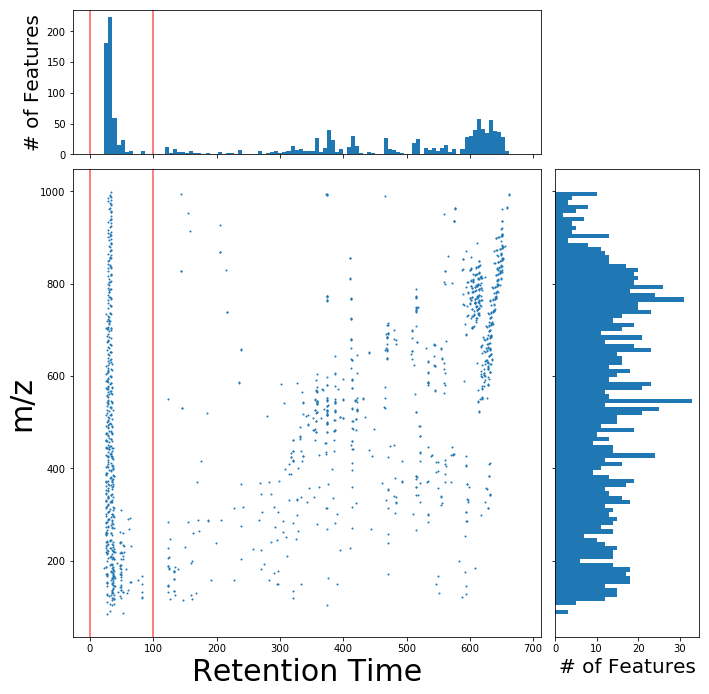

df_slice shape: (517, 262)
slice shape (254, 517)
y shape (254,)
0.0% done! 3.9871737957s elapsed


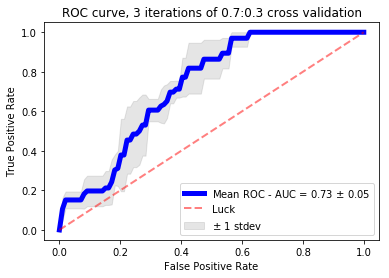

[0.78677685950413223, 0.71735537190082643, 0.67024793388429749]

In [74]:
import util.rt_window_prediction as rtwin

rtwin.slice_and_predict(df_filled, y, (0,100),
                       not_samples, n_iter=3
                       )

min: 0, max: 661.766511, width: 132.3533022, step: 66.1766511
[(0.0, 132.3533022), (66.176651100000001, 198.52995329999999), (132.3533022, 264.7066044), (198.52995329999999, 330.88325550000002), (264.7066044, 397.05990659999998), (330.88325550000002, 463.23655770000005), (397.05990659999998, 529.41320880000001), (463.23655769999999, 595.58985989999996), (529.41320880000001, 661.76651100000004)]
RT plot (0.0, 132.3533022)
661.766511
998.775098907


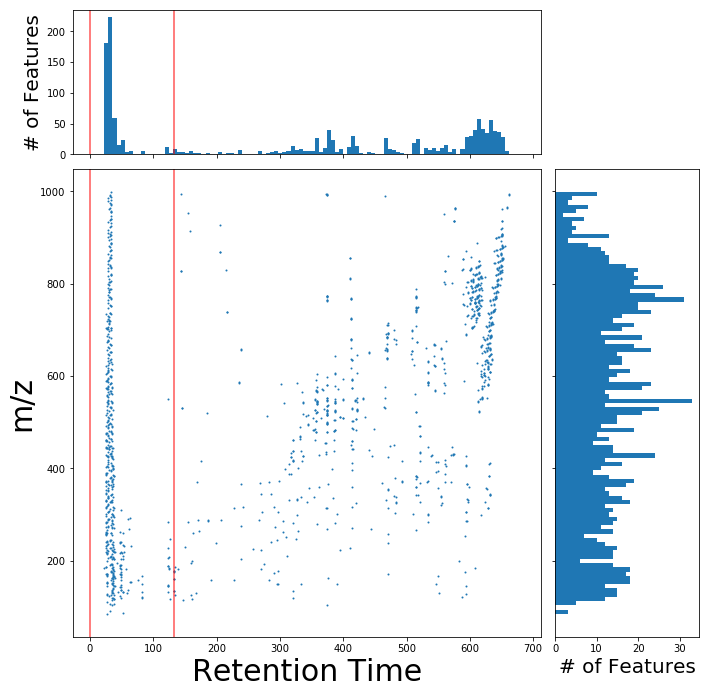

df_slice shape: (533, 262)
slice shape (254, 533)
y shape (254,)
0.0% done! 2.11139202118s elapsed


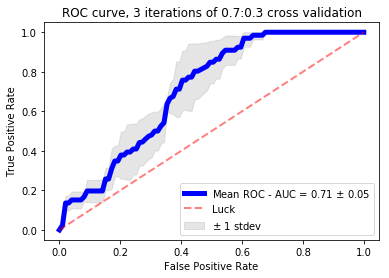




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (66.176651100000001, 198.52995329999999)
661.766511
998.775098907


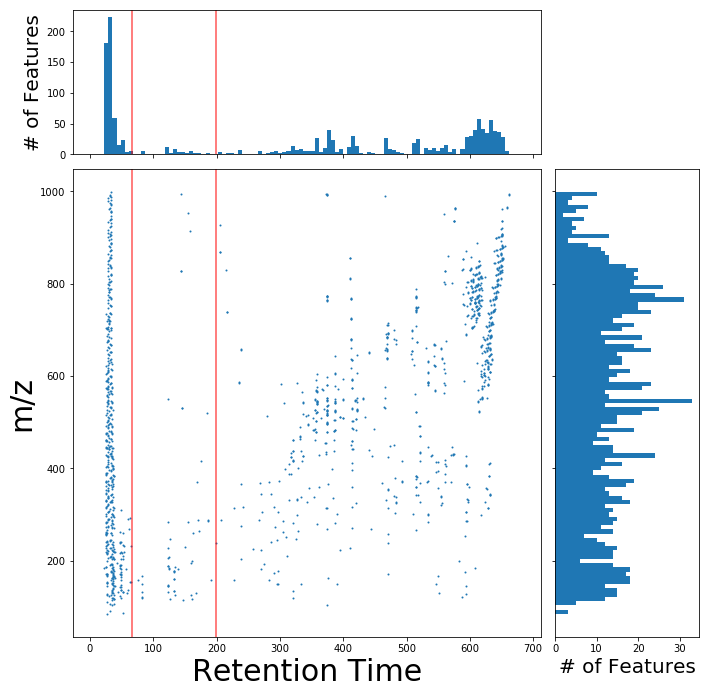

df_slice shape: (55, 262)
slice shape (254, 55)
y shape (254,)
0.0% done! 2.12693595886s elapsed


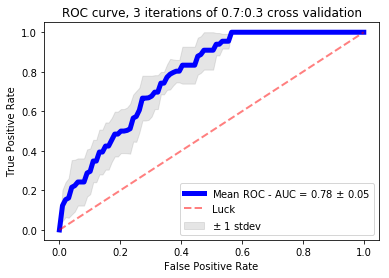




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (132.3533022, 264.7066044)
661.766511
998.775098907


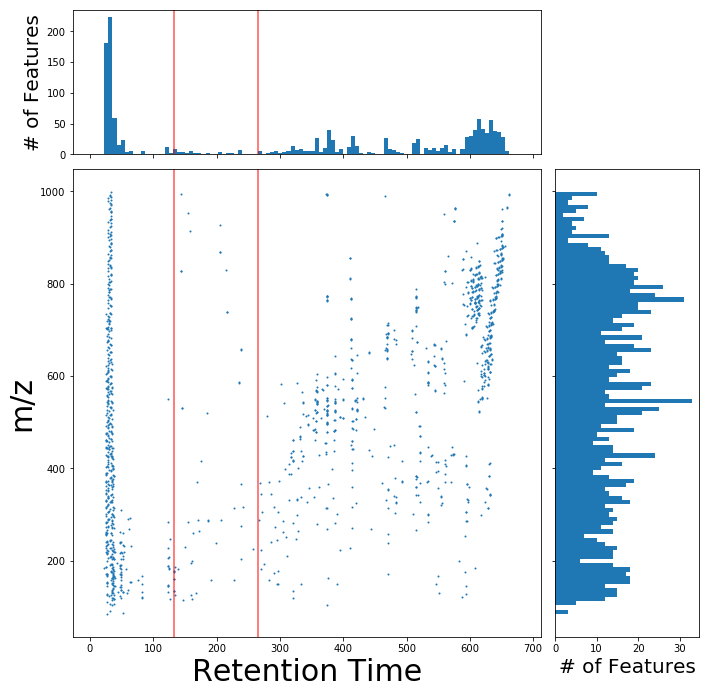

df_slice shape: (52, 262)
slice shape (254, 52)
y shape (254,)
0.0% done! 2.17781591415s elapsed


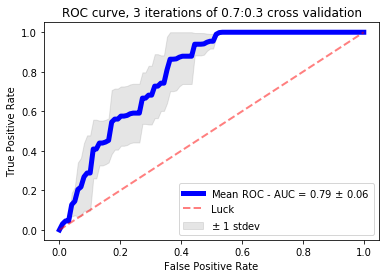




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (198.52995329999999, 330.88325550000002)
661.766511
998.775098907


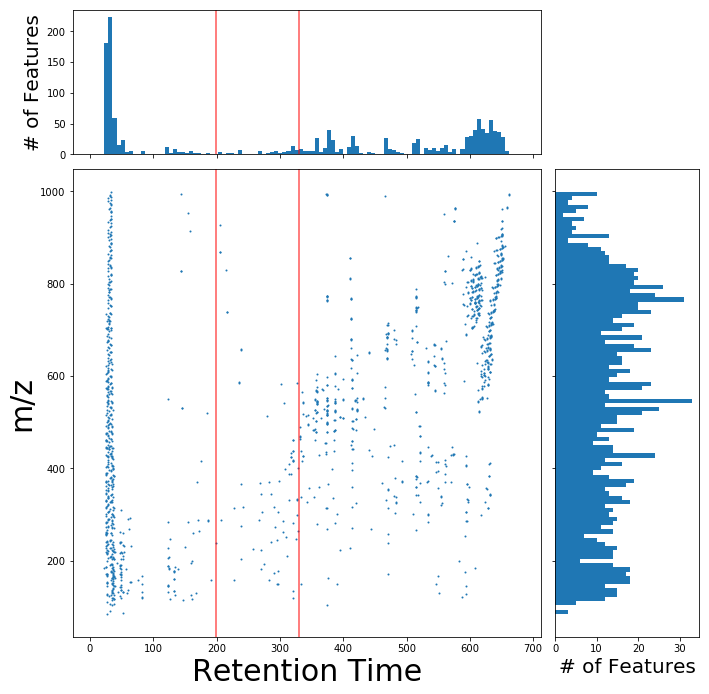

df_slice shape: (71, 262)
slice shape (254, 71)
y shape (254,)
0.0% done! 2.10322189331s elapsed


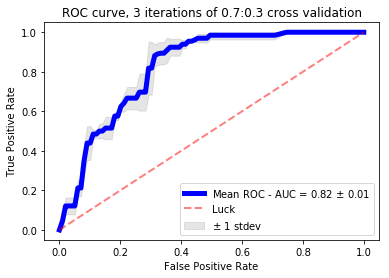




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (264.7066044, 397.05990659999998)
661.766511
998.775098907


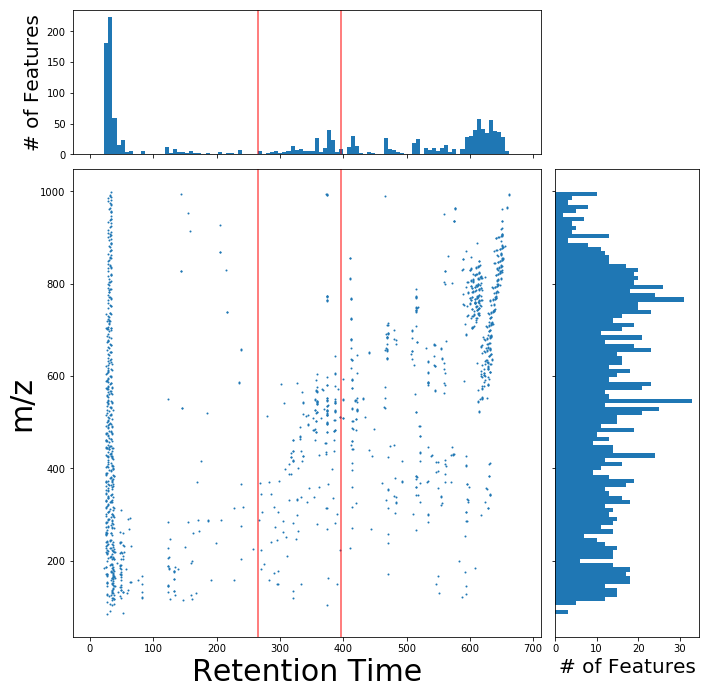

df_slice shape: (188, 262)
slice shape (254, 188)
y shape (254,)
0.0% done! 2.23831701279s elapsed


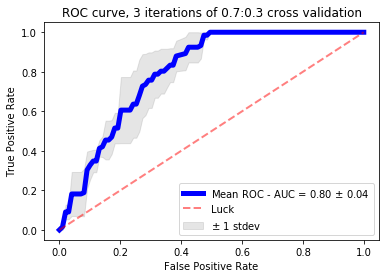




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (330.88325550000002, 463.23655770000005)
661.766511
998.775098907


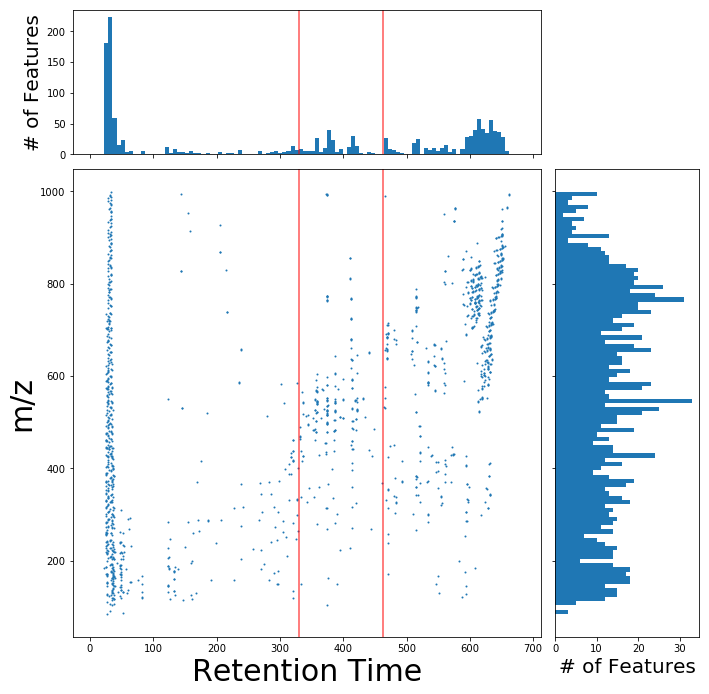

df_slice shape: (206, 262)
slice shape (254, 206)
y shape (254,)
0.0% done! 2.35306191444s elapsed


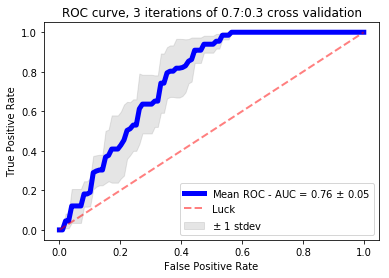




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (397.05990659999998, 529.41320880000001)
661.766511
998.775098907


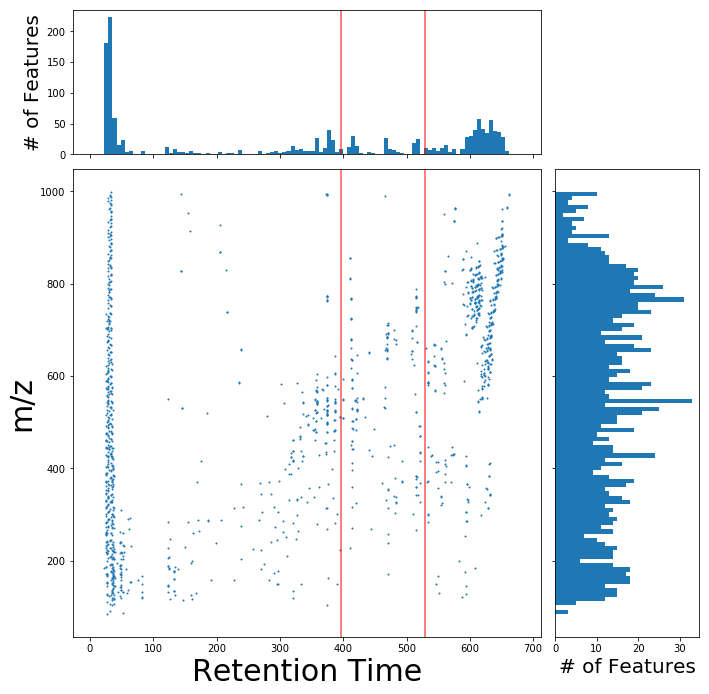

df_slice shape: (164, 262)
slice shape (254, 164)
y shape (254,)
0.0% done! 2.27836418152s elapsed


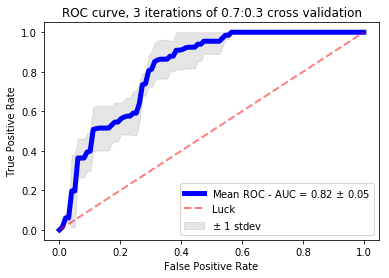




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (463.23655769999999, 595.58985989999996)
661.766511
998.775098907


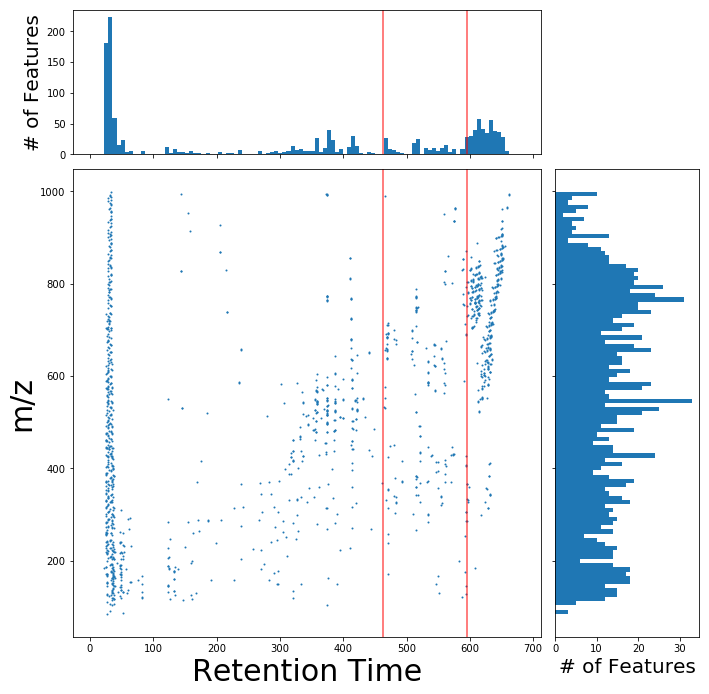

df_slice shape: (197, 262)
slice shape (254, 197)
y shape (254,)
0.0% done! 2.08123421669s elapsed


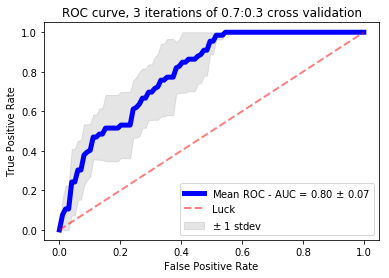




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (529.41320880000001, 661.76651100000004)
661.766511
998.775098907


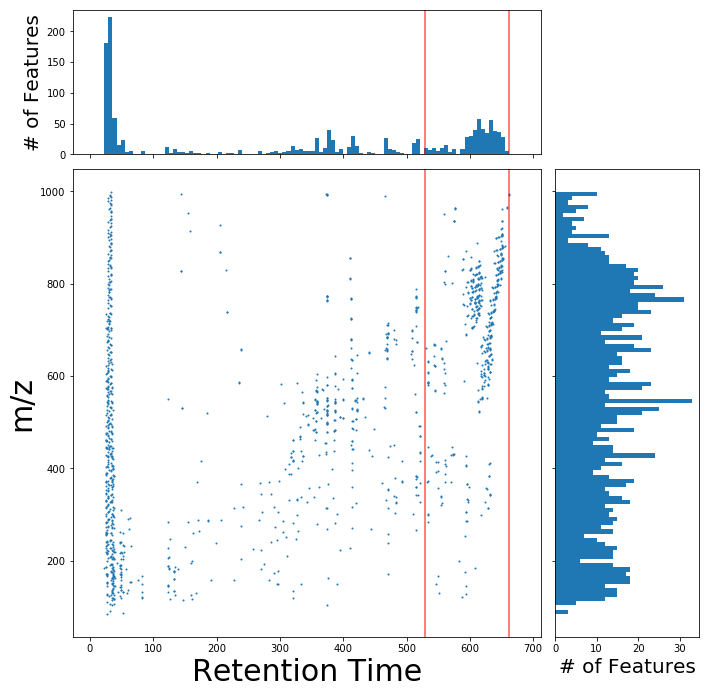

df_slice shape: (479, 262)
slice shape (254, 479)
y shape (254,)
0.0% done! 2.52601289749s elapsed


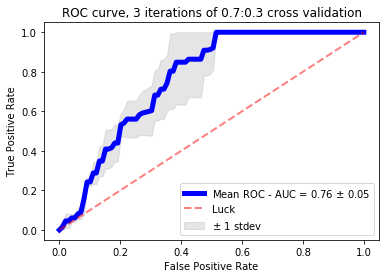




--------------------------------------------------NEXT ROUND--------------------------------------------------





In [75]:
# run a sliding windonw
# Make sliding window
min_val = 0
max_val = df['rt'].max()
width = max_val / 5.0
step = width / 2
print "min: {mini}, max: {maxi}, width: {width}, step: {step}".format(
        mini=min_val, maxi=max_val, width=width, step=step)
sliding_window = rtwin.make_sliding_window(min_val, 
                                           max_val, width, step)
print sliding_window

# plot and run classifier on sliding window
for rt_slice in sliding_window:
    print 'RT plot', rt_slice
    rtwin.slice_and_predict(df_filled, y, rt_slice,
                            not_samples, rf_estimators=500, 
                     n_iter=3, test_size=0.3, random_state=1)
    print '\n\n\n'+'-'*50+'NEXT ROUND'+'-'*50+'\n\n\n'

In [10]:
# TODO pqn-normalize this bad-boy and plot the difference in 
# mw histograms, then try to classify it
def pqn_normalize(X, plot=True):
    '''
    X - (samples x features) dataframe 
    '''
    feature_means = np.mean(X, axis=0)
    # mean-center each feature
    X_mean_centered = np.divide(X, feature_means[np.newaxis,:])
    # ignore the nans 
    dilution_factors = np.nanmedian(X_mean_centered, axis=1)
    if plot:
        plt.hist(dilution_factors, bins=50)
        plt.title('Dilution factor distribution')
        plt.show()
    # broadcast correctly
    X_pqn = np.divide(X, dilution_factors[:,np.newaxis] )
    return X_pqn


X_df_raw = df[samples_list].T
X_df_filled = df_filled[samples_list].T
X_pqn_df_raw = pqn_normalize(X_df_raw)
X_pqn_df_filled = pqn_normalize(X_df_filled)


NameError: name 'df_filled' is not defined

In [159]:
# Any nan's in df_filled
print df.shape
print 'original',(df.isnull()).sum().sum()
print 'filled', (df_filled.isnull()).sum().sum()

print '\n\npqn_original', (X_pqn_df_raw.isnull()).sum().sum()
print 'filled pqn', (X_pqn_df_filled.isnull()).sum().sum()

(1417, 262)
original 83441
filled 0


pqn_original 83441
filled pqn 0


Raw intensities




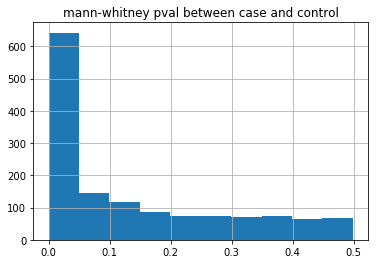

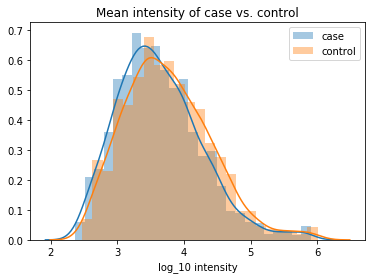

pval (MannW) of intensities between case and control:  6.1537580727e-08
**************************************************
NaN filled with 1/2 min


NameError: name 'X_df_filled' is not defined

In [11]:
# Do mann-whitney on case vs control
def mw_pval_dist(case, control):
    '''
    case - dataframe containing case
    control - dataframe with control samples
        All should have same features (columns)
    '''
    # get parametric pvals
    mann_whitney_vals = pd.DataFrame(np.full([case.shape[1],2], np.nan),
                              index=case.columns, columns= ['u', 'pval'])
    for idx, case_vals in case.iteritems():
        control_vals = control[idx]
        u, pval = stats.mannwhitneyu(case_vals, control_vals)
        mann_whitney_vals.loc[idx, 'u'] = u
        mann_whitney_vals.loc[idx, 'pval'] = pval
    
    # plot mw pval distribution
    mann_whitney_vals.hist('pval')
    plt.title('mann-whitney pval between case and control')
    plt.show()
    
    # plot distribution of mean intensities
    case_mean = case[case > 10].mean(axis=0)
    ctrl_mean = control[control>10].mean(axis=0)
    sns.distplot(np.log10(case_mean), label='case')
    sns.distplot(np.log10(ctrl_mean), label='control')
    plt.xlabel('log_10 intensity')
    plt.title('Mean intensity of case vs. control')
    plt.legend()
    plt.show()
    u, pval = stats.mannwhitneyu(case_mean, ctrl_mean)
    print 'pval (MannW) of intensities between case and control: ', pval
    
print('Raw intensities\n\n')
mw_pval_dist(X_df_raw.loc[case_labels], X_df_raw.loc[control_labels])

print('*'*50+'\nNaN filled with 1/2 min')
mw_pval_dist(X_df_filled.loc[case_labels], X_df_filled.loc[control_labels])

print('*'*50+'\n Raw pqn_normalized')
mw_pval_dist(X_pqn_df_raw.loc[case_labels], X_pqn_df_raw.loc[control_labels])

print('*'*50+'\n NaN filled with 1/2 min, pqn normalized')
mw_pval_dist(X_pqn_df_filled.loc[case_labels], X_pqn_df_filled.loc[control_labels])



<h2> Dilution-factor normalizing (pqn) worked! </h2>
Now re-run the code on the pqn-normalized, nan-filled data

min: 0, max: 661.766511, width: 132.3533022, step: 66.1766511
[(0.0, 132.3533022), (66.176651100000001, 198.52995329999999), (132.3533022, 264.7066044), (198.52995329999999, 330.88325550000002), (264.7066044, 397.05990659999998), (330.88325550000002, 463.23655770000005), (397.05990659999998, 529.41320880000001), (463.23655769999999, 595.58985989999996), (529.41320880000001, 661.76651100000004)]
RT plot (0.0, 132.3533022)
661.766511
998.775098907


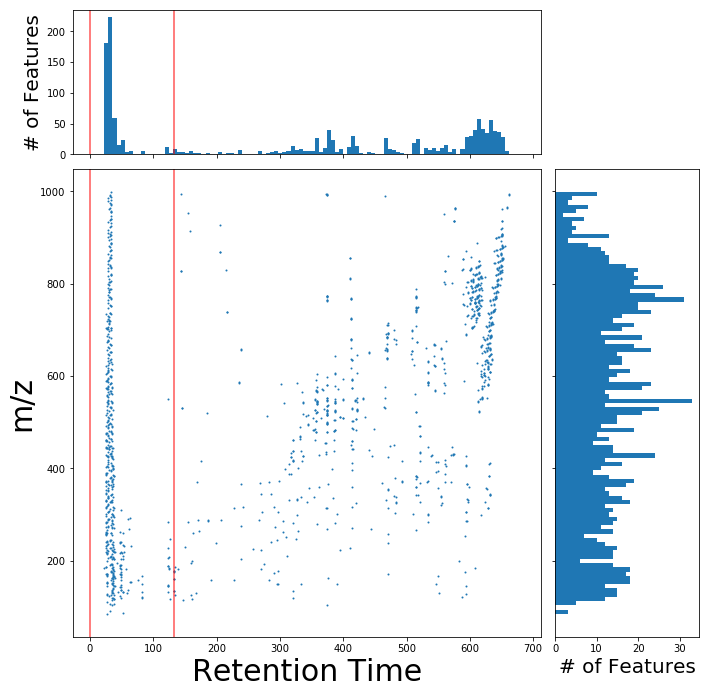

slice shape (254, 533)
y shape (254,)
0.0% done! 2.36461806297s elapsed


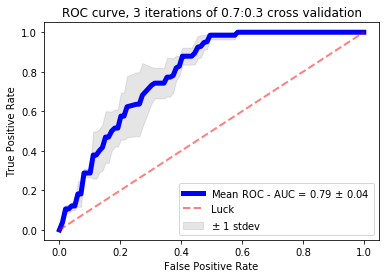




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (66.176651100000001, 198.52995329999999)
661.766511
998.775098907


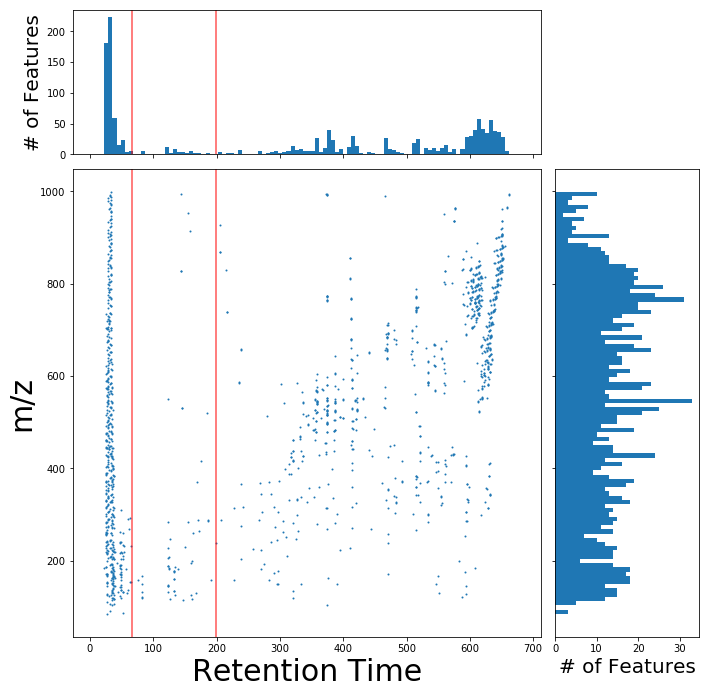

slice shape (254, 55)
y shape (254,)
0.0% done! 1.68869996071s elapsed


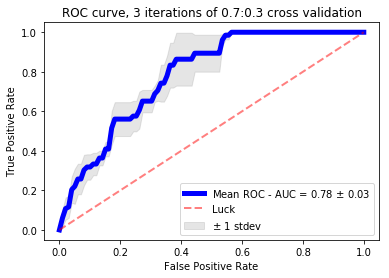




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (132.3533022, 264.7066044)
661.766511
998.775098907


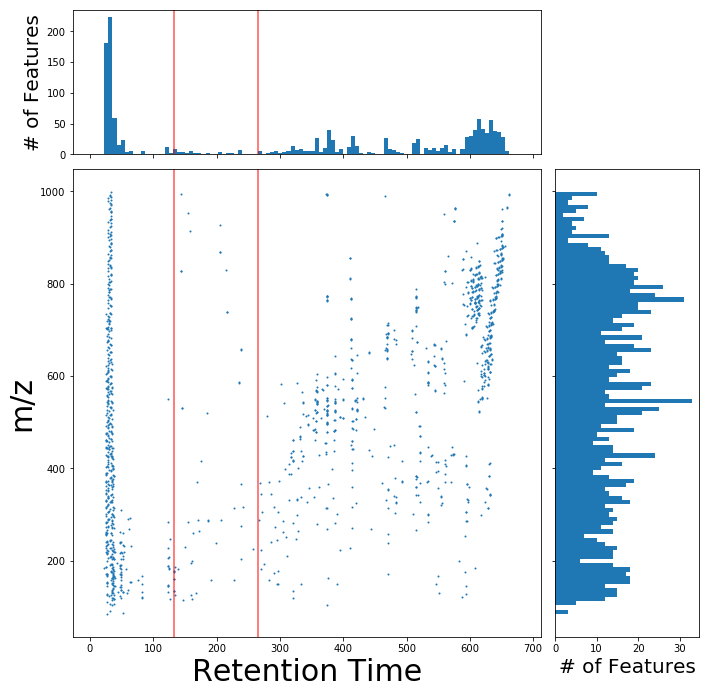

slice shape (254, 52)
y shape (254,)
0.0% done! 1.92607402802s elapsed


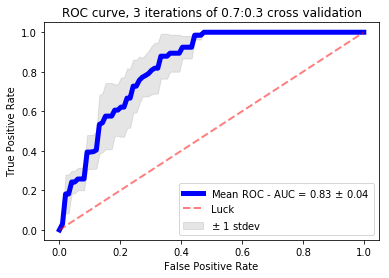




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (198.52995329999999, 330.88325550000002)
661.766511
998.775098907


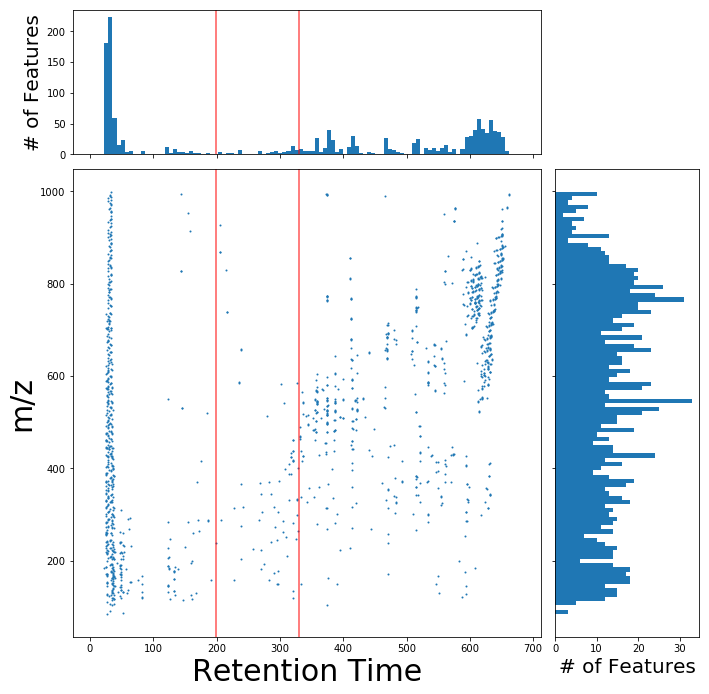

slice shape (254, 71)
y shape (254,)
0.0% done! 1.85135102272s elapsed


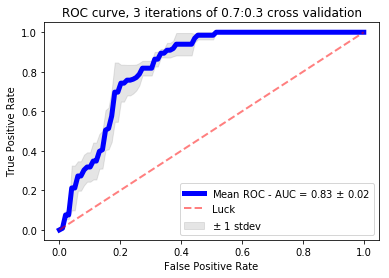




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (264.7066044, 397.05990659999998)
661.766511
998.775098907


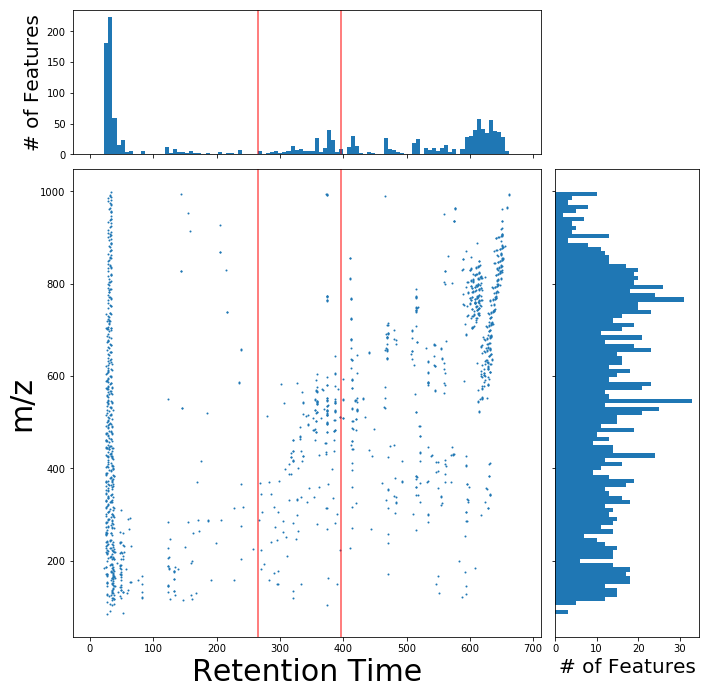

slice shape (254, 188)
y shape (254,)
0.0% done! 2.08887505531s elapsed


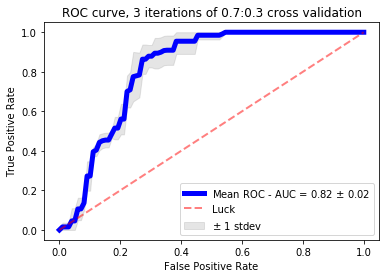




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (330.88325550000002, 463.23655770000005)
661.766511
998.775098907


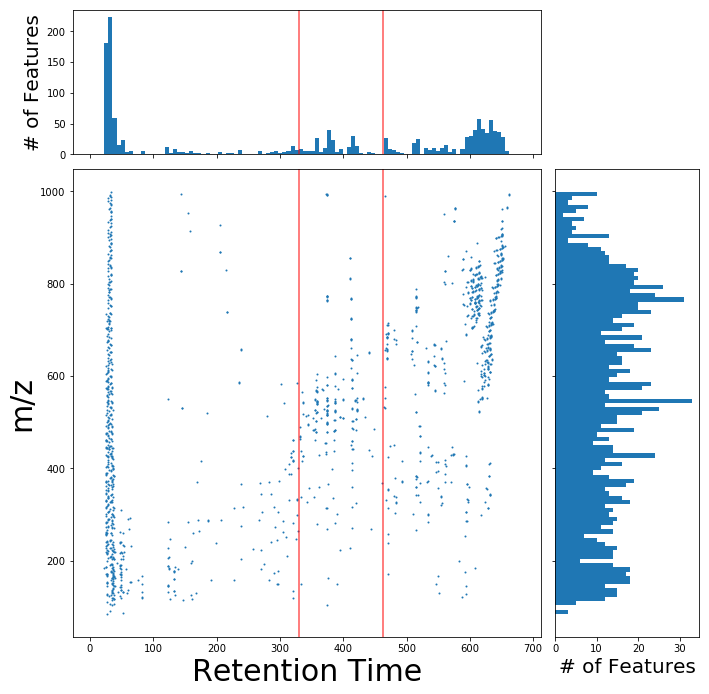

slice shape (254, 206)
y shape (254,)
0.0% done! 1.9940199852s elapsed


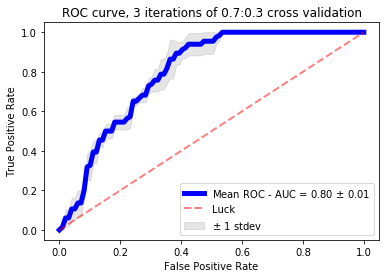




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (397.05990659999998, 529.41320880000001)
661.766511
998.775098907


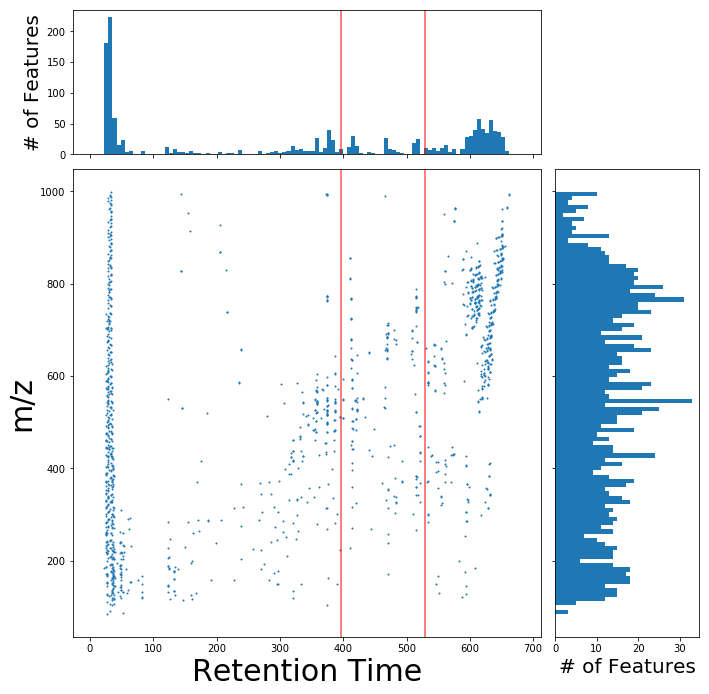

slice shape (254, 164)
y shape (254,)
0.0% done! 1.87996912003s elapsed


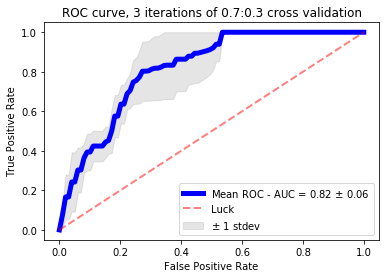




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (463.23655769999999, 595.58985989999996)
661.766511
998.775098907


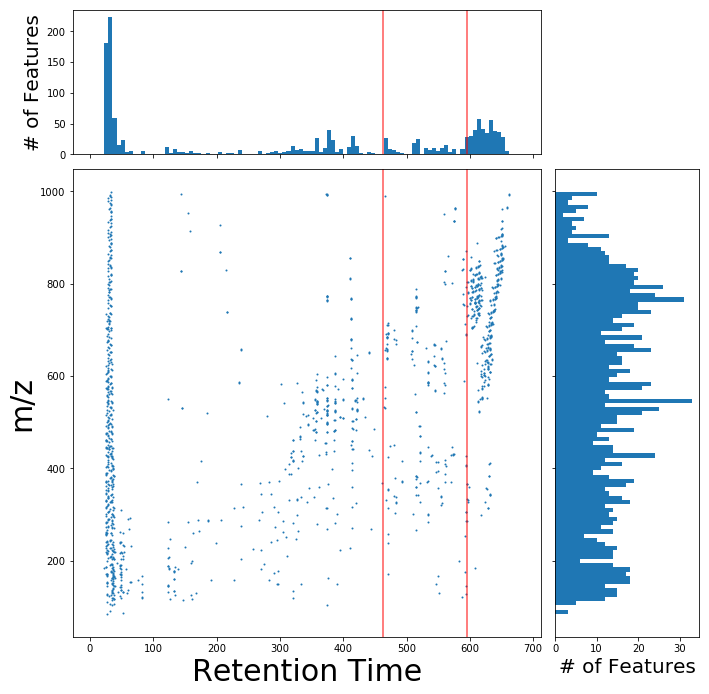

slice shape (254, 197)
y shape (254,)
0.0% done! 1.82916903496s elapsed


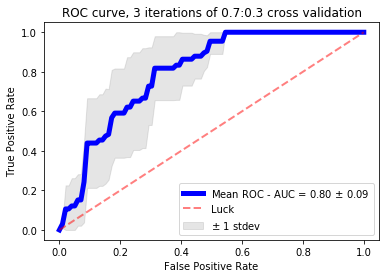




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (529.41320880000001, 661.76651100000004)
661.766511
998.775098907


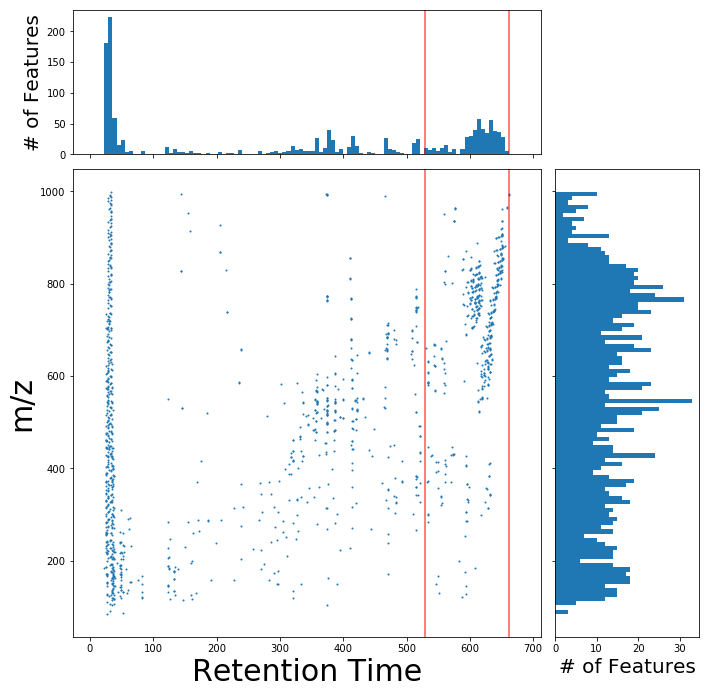

slice shape (254, 479)
y shape (254,)
0.0% done! 2.51903986931s elapsed


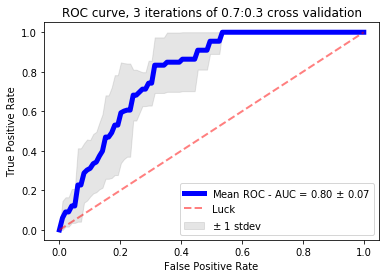




--------------------------------------------------NEXT ROUND--------------------------------------------------





In [178]:
# Add back mz, rt, etc. columns to feature table and reshape it to be
# (feats x samples)
X_pqn_df_filled_mzrt = pd.concat([df[not_samples].T, X_pqn_df_filled], 
                                 axis=0).T

# run a sliding windonw
# Make sliding window
min_val = 0
max_val = df['rt'].max()
width = max_val / 5.0
step = width / 2
print "min: {mini}, max: {maxi}, width: {width}, step: {step}".format(
        mini=min_val, maxi=max_val, width=width, step=step)
sliding_window = rtwin.make_sliding_window(min_val, 
                                           max_val, width, step)
print sliding_window

# plot and run classifier on sliding window
for rt_slice in sliding_window:
    print 'RT plot', rt_slice
    rtwin.slice_and_predict(X_pqn_df_filled_mzrt, y, rt_slice,
                            not_samples, rf_estimators=500, 
                     n_iter=3, test_size=0.3, random_state=1)
    print '\n\n\n'+'-'*50+'NEXT ROUND'+'-'*50+'\n\n\n'
    

min: 0, max: 661.766511, width: 132.3533022, step: 66.1766511
[(0.0, 132.3533022), (66.176651100000001, 198.52995329999999), (132.3533022, 264.7066044), (198.52995329999999, 330.88325550000002), (264.7066044, 397.05990659999998), (330.88325550000002, 463.23655770000005), (397.05990659999998, 529.41320880000001), (463.23655769999999, 595.58985989999996), (529.41320880000001, 661.76651100000004)]
RT plot (0.0, 132.3533022)
661.766511
998.775098907


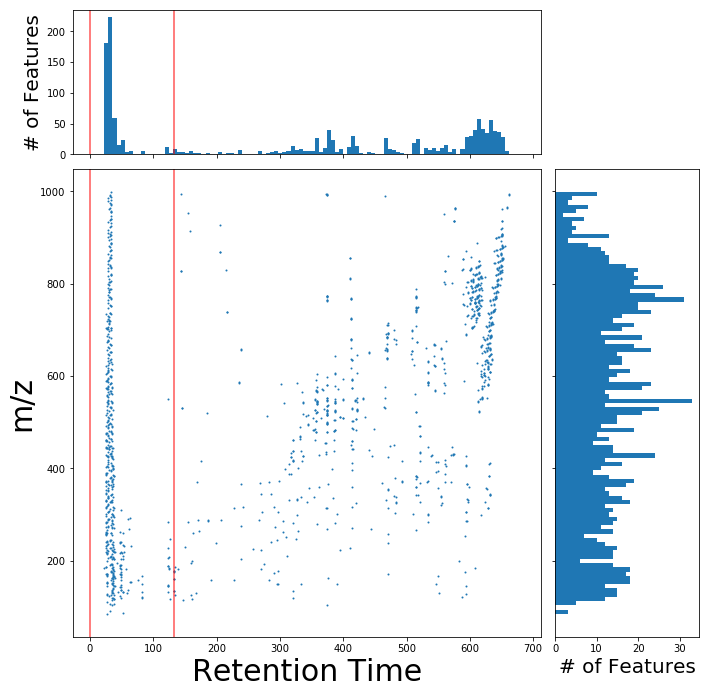

slice shape (254, 533)
y shape (254,)
0.0% done! 2.41095995903s elapsed


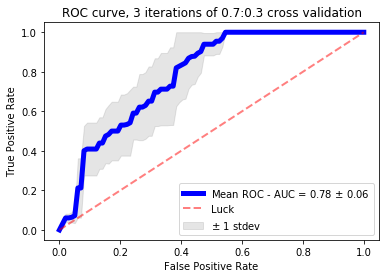




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (66.176651100000001, 198.52995329999999)
661.766511
998.775098907


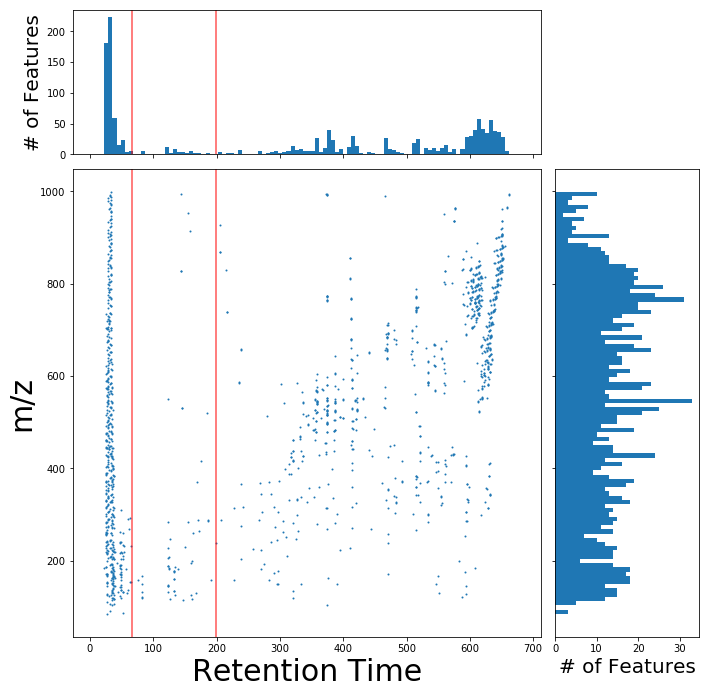

slice shape (254, 55)
y shape (254,)
0.0% done! 1.84250307083s elapsed


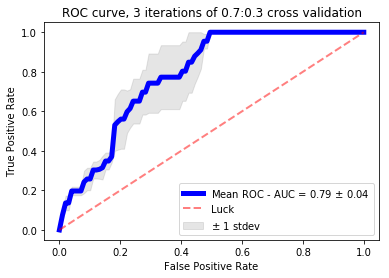




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (132.3533022, 264.7066044)
661.766511
998.775098907


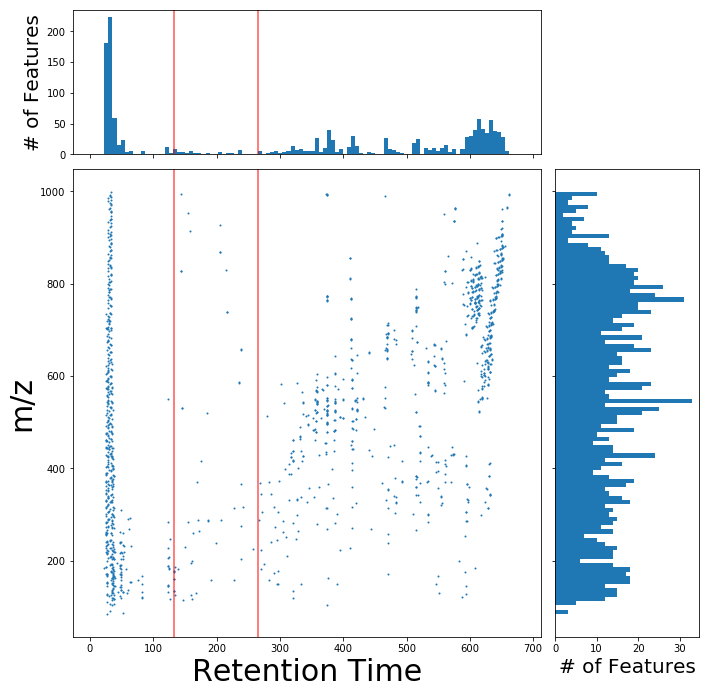

slice shape (254, 52)
y shape (254,)
0.0% done! 1.90042209625s elapsed


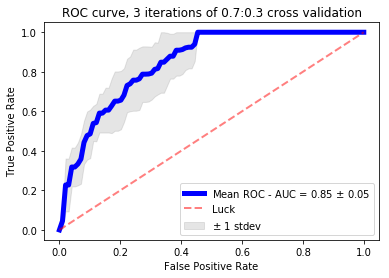




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (198.52995329999999, 330.88325550000002)
661.766511
998.775098907


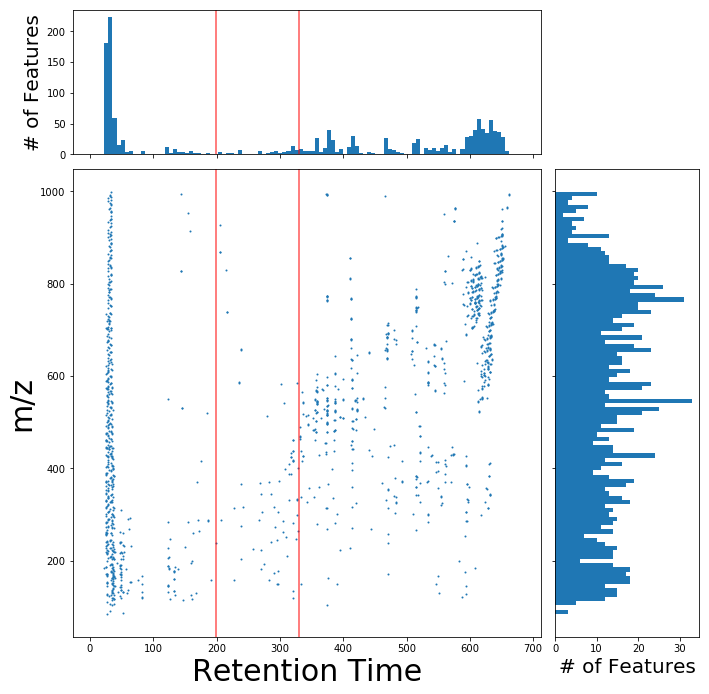

slice shape (254, 71)
y shape (254,)
0.0% done! 1.84670495987s elapsed


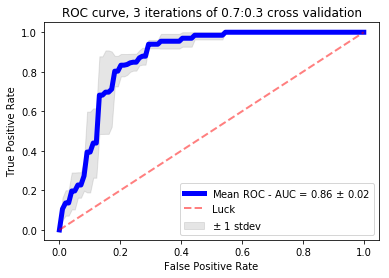




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (264.7066044, 397.05990659999998)
661.766511
998.775098907


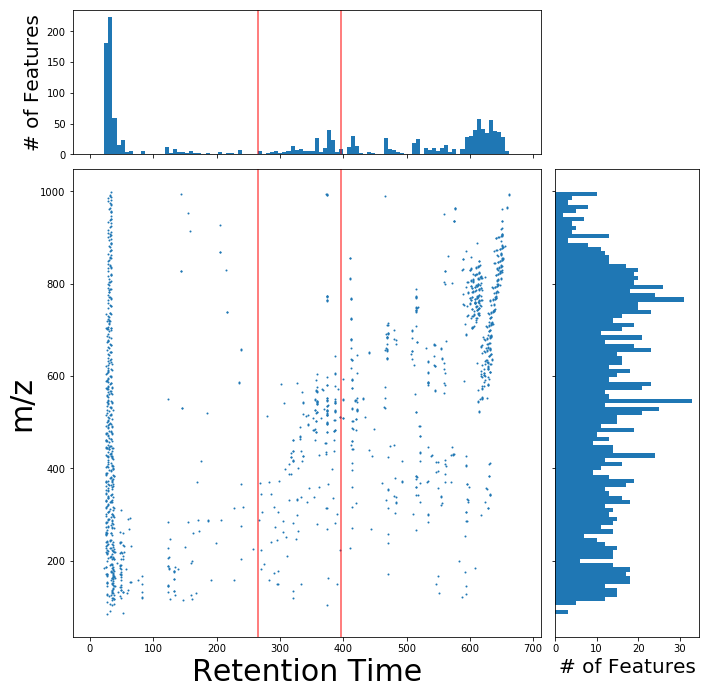

slice shape (254, 188)
y shape (254,)
0.0% done! 2.13120913506s elapsed


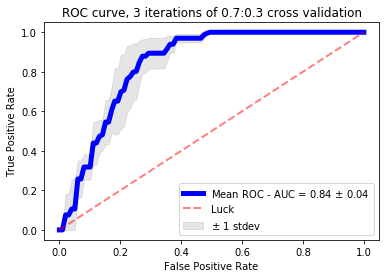




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (330.88325550000002, 463.23655770000005)
661.766511
998.775098907


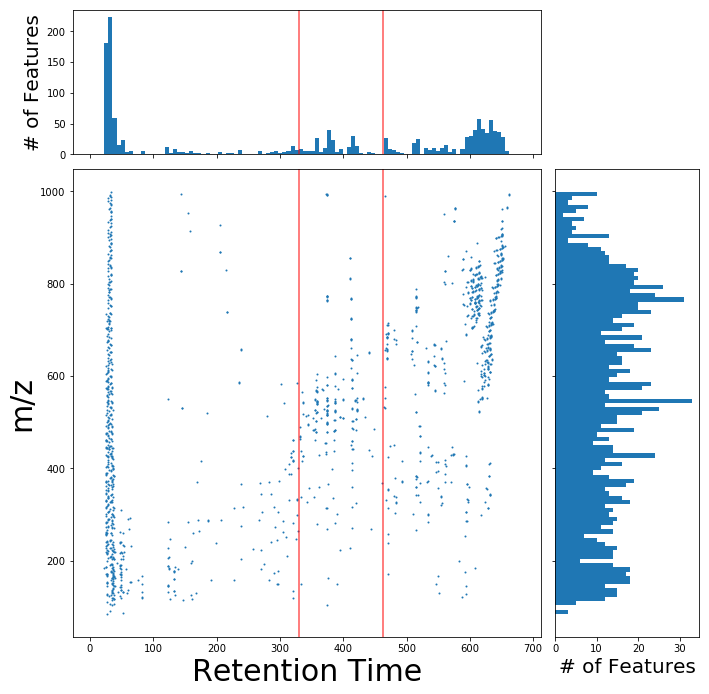

slice shape (254, 206)
y shape (254,)
0.0% done! 2.09929895401s elapsed


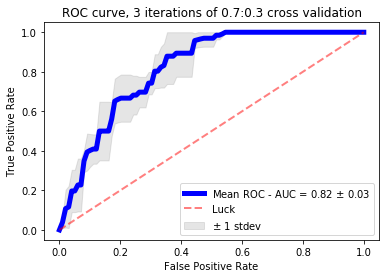




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (397.05990659999998, 529.41320880000001)
661.766511
998.775098907


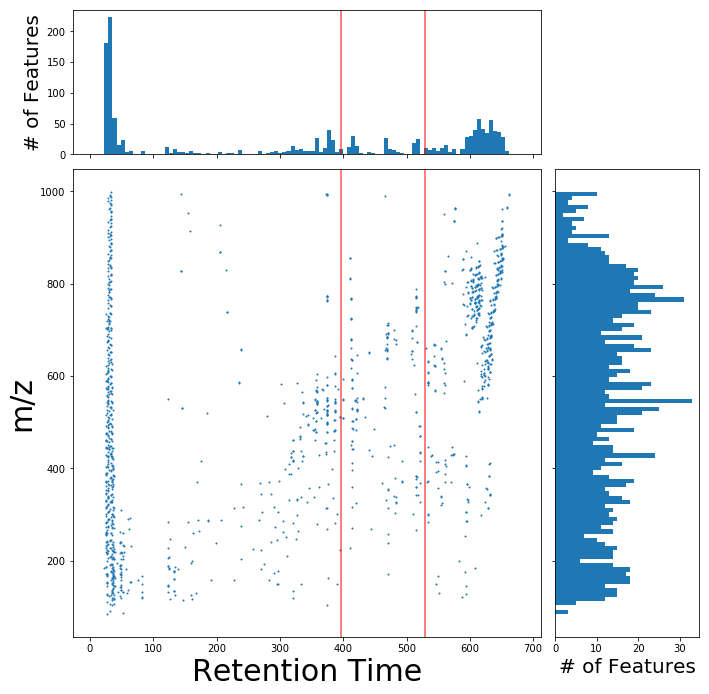

slice shape (254, 164)
y shape (254,)
0.0% done! 2.07512903214s elapsed


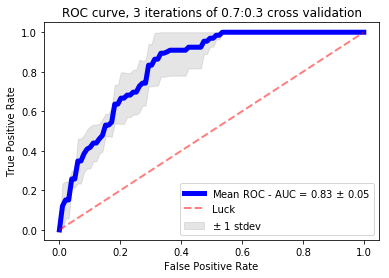




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (463.23655769999999, 595.58985989999996)
661.766511
998.775098907


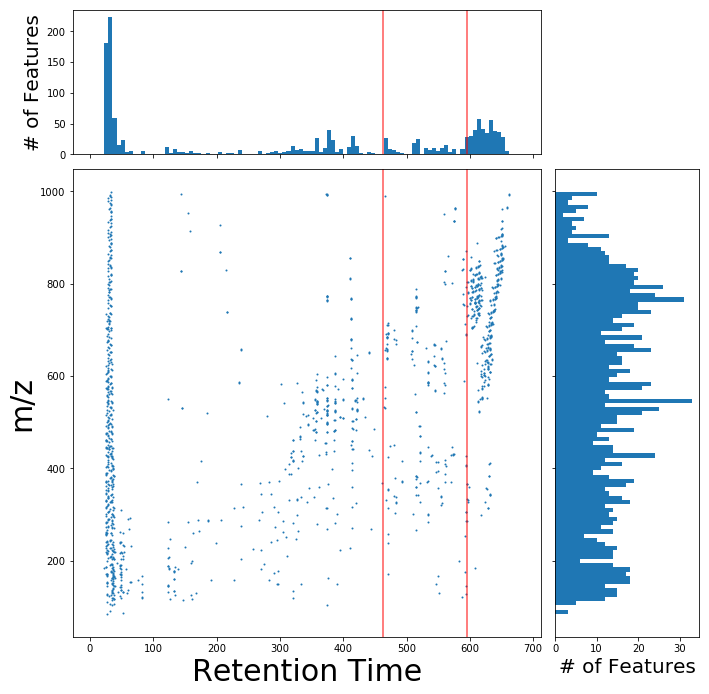

slice shape (254, 197)
y shape (254,)
0.0% done! 1.810765028s elapsed


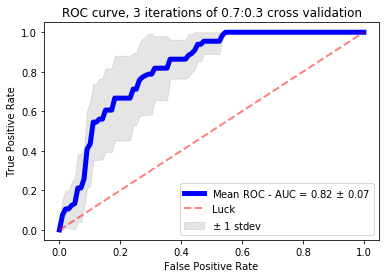




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (529.41320880000001, 661.76651100000004)
661.766511
998.775098907


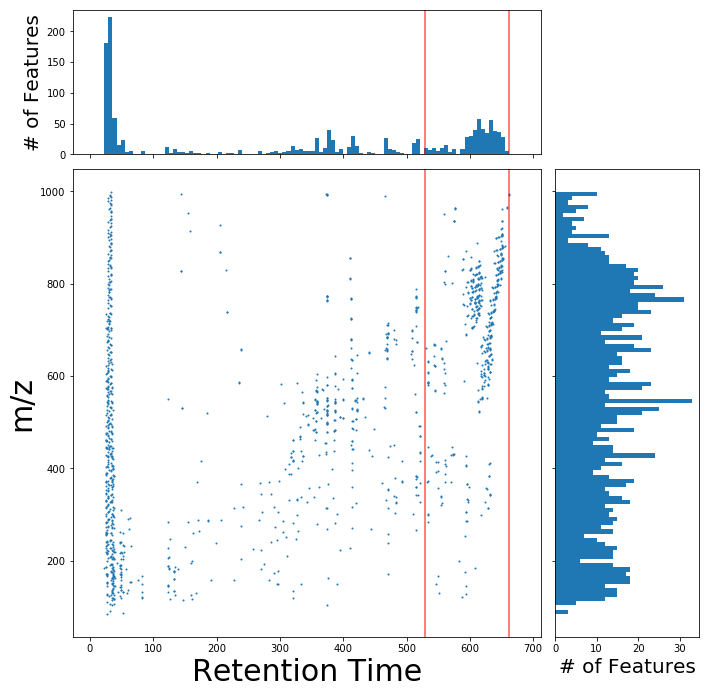

slice shape (254, 479)
y shape (254,)
0.0% done! 2.38983392715s elapsed


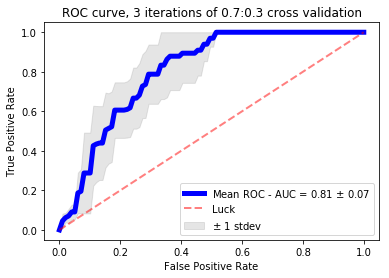




--------------------------------------------------NEXT ROUND--------------------------------------------------





In [181]:
# Add back mz, rt, etc. columns to feature table and reshape it to be
# (feats x samples)
X_pqn_df_raw_mzrt = pd.concat([df[not_samples].T, X_pqn_df_raw], 
                                 axis=0).T
# fill vals with half min
half_min = X_pqn_df_raw_mzrt.min(axis=0) / 2.0
X_pqn_df_raw_mzrt = X_pqn_df_raw_mzrt.fillna(value=half_min, axis=0)

# run a sliding windonw
# Make sliding window
min_val = 0
max_val = df['rt'].max()
width = max_val / 5.0
step = width / 2
print "min: {mini}, max: {maxi}, width: {width}, step: {step}".format(
        mini=min_val, maxi=max_val, width=width, step=step)
sliding_window = rtwin.make_sliding_window(min_val, 
                                           max_val, width, step)
print sliding_window

# plot and run classifier on sliding window
n_iter = 3
test_size = 0.3
rf_trees = 1000

for rt_slice in sliding_window:
    print 'RT plot', rt_slice
    rtwin.slice_and_predict(X_pqn_df_raw_mzrt, y, rt_slice,
                            not_samples, rf_estimators=rf_trees, 
                     n_iter=n_iter, test_size=test_size, random_state=1)
    print '\n\n\n'+'-'*50+'NEXT ROUND'+'-'*50+'\n\n\n'
    

<h2> TODO </h2>
Looks like even after getting rid of the systematic bias in intensities, there are still about 1/2 of all features that are strongly discriminatory. That seems fishy..?

<h2> Press on despite the issue </h2>
Just get the auc's and plot them vs. retention time, or
rt/max(rt)